### This ananlysis uses FPL dataset from FPL API. The ultimate goal is to be able to build models so that we can predict player points for the upcoming FPL game week.

Specifically, we will: 
    
    1. Load in the FPL players datasets in JSON
    2. Build pandas dataframes for 22/23 season with current price
    3. Conduct some EDA
    4. Split the data into train and test
    5. Find the optimal parameters for each model and evaluate performance
    6. Fit the models for prediction
    7. Make prediction

    
Hopefully after this analysis we will be able to answer the following questions: 
 - How to obtain FPL dataset in desired format ready for analysis?
 - What are the valuable players based on previous season performance given current price?
 - What are some good predictors of FPL player points for the upcoming game week?
 - What predictors are correlated, therefore should be dropped before modelling?
 - How to construct modelling to balance bias and variance?
 - How to finetune model parameters to avoid overfitting?
 - What is the predicted player points for upcoming FPL game week using models trained?

In [881]:
# importing necessary libraries

# essentials
import numpy as np
import pandas as pd
import datetime
import requests
import json
from IPython.display import HTML
from numpy.random import random

# webscrapping
from bs4 import BeautifulSoup

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.subplots import make_subplots
import plotly.graph_objs as go

# modeling
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# stats
import scipy.stats as stats
import pylab
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# miscellenous
import warnings
import chardet
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### A detailed guide to all currently available Fantasy Premier League API endpoints: 
https://medium.com/@frenzelts/fantasy-premier-league-api-endpoints-a-detailed-guide-acbd5598eb19

In [882]:
# function to request json over url
def getJson(base_url, end_point_path, element_id=''):
    return requests.get(base_url+end_point_path+str(element_id)).json()

In [883]:
# get json data
base_url = 'https://fantasy.premierleague.com/api/'
end_point_general = 'bootstrap-static'
end_point_fixtures = 'fixtures'
end_point_player = 'element-summary/'

json = getJson(base_url, end_point_general)
# check keys
json.keys()

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])

#### Desired data
##### Dataframe #1:
- all 38 game week of season 22/23
- all 10 games of each 38 game week of season 22/23
- all players involved [i.e. ~(11 + 4) x 2] for all 10 games in each 38 game week of season 22/23

Expected number of records = 38 x 10 x (11 + 4) x 2 = ~11.4K

##### Dataframe #2:
- current player info including cost, position etc.

##### Dataframe #3:
- Join df1 and df2 to get aggregated df for info

In [884]:
# build dataframes
df_elements = pd.DataFrame(json['elements'])
df_elements_types = pd.DataFrame(json['element_types'])
df_teams = pd.DataFrame(json['teams'])
total_players = json['total_players']
percentile = 0.8

df_elements_short = df_elements[['id', 'first_name', 'second_name','team','element_type','selected_by_percent','now_cost','minutes','transfers_in','value_season','event_points', 'total_points']]

# restructure player dataframe
df_elements_short['position'] = df_elements_short.element_type.map(df_elements_types.set_index('id').singular_name)
df_elements_short['team'] = df_elements_short.team.map(df_teams.set_index('id').name)
df_elements_short['name'] = df_elements_short['first_name'] + ' ' + df_elements_short['second_name']
df_elements_short['points_per_minute'] = df_elements_short['total_points'] / df_elements_short['minutes']
df_elements_short['points_per_minute'] = df_elements_short['points_per_minute'].fillna(0)
df_elements_short['now_cost'] = df_elements_short['now_cost'] / 10
df_elements_short['ppm_over_cost'] = df_elements_short['points_per_minute'] / df_elements_short['now_cost']
df_elements_short = df_elements_short[df_elements_short['minutes'] >= df_elements_short['minutes'].quantile(percentile)]
df_elements_short = df_elements_short[['id', 'name', 'team', 'position', 'selected_by_percent', 'minutes', 'now_cost', 'points_per_minute', 'ppm_over_cost']]

In [885]:
# show value players
df_elements_short = df_elements_short.sort_values(by=['ppm_over_cost'], ascending=False)
df_elements_short.groupby(['position']).head(5)

,id,name,team,position,selected_by_percent,minutes,now_cost,points_per_minute,ppm_over_cost
25,26,Leandro Trossard,Arsenal,Midfielder,4.0,2237,7.0,0.068842,0.009835
427,402,Miguel Almirón Rejala,Newcastle,Midfielder,7.1,2487,6.5,0.063530,0.009774
290,275,Bernd Leno,Fulham,Goalkeeper,8.6,3240,4.5,0.043827,0.009739
118,113,David Raya Martin,Brentford,Goalkeeper,8.9,3420,5.0,0.048538,0.009708
19,20,William Saliba,Arsenal,Defender,14.9,2415,5.0,0.048447,0.009689
156,151,Joël Veltman,Brighton,Defender,1.3,2183,4.5,0.043518,0.009671
529,495,Ben Davies,Spurs,Defender,0.7,2284,4.5,0.043345,0.009632
136,131,Pervis Estupiñán,Brighton,Defender,51.0,2674,5.0,0.047868,0.009574
402,377,Diogo Dalot Teixeira,Man Utd,Defender,2.0,2152,5.0,0.047398,0.009480
238,226,Eberechi Eze,Crystal Palace,Midfielder,12.3,2631,6.5,0.060433,0.009297


In [886]:
df_mo = df_elements_short[(df_elements_short['name']=='Mohamed Salah')]
df_mo

,id,name,team,position,selected_by_percent,minutes,now_cost,points_per_minute,ppm_over_cost
326,308,Mohamed Salah,Liverpool,Midfielder,24.3,3290,12.5,0.072644,0.005812


In [887]:
element_id = 308
json = getJson(base_url, end_point_player, element_id)
# check keys
json.keys()

dict_keys(['fixtures', 'history', 'history_past'])

In [888]:
df_player_mo = pd.DataFrame(json['history_past'])
df_player_mo.tail()

,season_name,element_code,start_cost,end_cost,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded
3,2018/19,118748,130,132,259,3254,22,12,21,20,0,0,0,1,0,0,18,687,1186.8,973.9,2168.0,432.7,0,0.00,0.00,0.00,0.00
4,2019/20,118748,125,125,233,2879,19,10,16,26,0,0,0,1,0,0,26,661,1061.2,834.8,2156.0,405.1,0,0.00,0.00,0.00,0.00
5,2020/21,118748,120,129,231,3077,22,6,11,41,0,0,0,0,0,0,21,657,1056.0,825.7,1980.0,385.8,0,0.00,0.00,0.00,0.00
6,2021/22,118748,125,131,265,2758,23,14,17,22,0,0,1,1,0,0,29,756,1241.0,875.9,2230.0,434.8,0,0.00,0.00,0.00,0.00
7,2022/23,118748,130,131,239,3290,19,13,13,45,0,0,2,2,0,0,23,651,1067.4,899.2,1688.0,365.6,37,21.01,7.03,28.04,47.47


##### Data limiation
From observation above, FPL API doesn't have player level game week data for past seasons

##### Solution
Use github repo https://github.com/vaastav/Fantasy-Premier-League/tree/master loaded to local repo

In [889]:
# helper functions to retrieve players master dataframe based on seasons interested
def getEncoding(file):
    with open(file, 'rb') as rawdata:
        result = chardet.detect(rawdata.read(100000))
    return result['encoding']

def getMasterDataFrame(seasons):
    for i, season in enumerate(seasons):

        file = 'Fantasy-Premier-League/data/'+ season +'/gws/merged_gw.csv'
        encoding = getEncoding(file)

        if i == 0:
            df_master = pd.read_csv(file, encoding=encoding)
            df_master['season'] = season
        else:
            df_temp = pd.read_csv(file, encoding=encoding)
            df_temp['season'] = season
            df_master = pd.concat([df_master, df_temp], ignore_index=True)
    return df_master

In [890]:
# retrieve player master dataframe by specifying seasons intended to pull
# i.e. to pull player data for season 22/23, assign seasons = ['2022-23']
seasons = ['2022-23']

df_master = getMasterDataFrame(seasons)

In [891]:
df_master = df_master.merge(df_elements_short[['name','selected_by_percent', 'now_cost']], on='name', how='left')

In [892]:
# validation with seasonally aggregated data for Salah above
df_mo = df_master[df_master['name'].str.contains('Salah')]
df_mo.groupby(['season'])['minutes'].sum()

season
2022-23    3290
Name: minutes, dtype: int64

Validation complete, numbers match for seasons 22/23, 21/22 and 20/21

In [893]:
# calculate efficient frontier player metrics
df_eft_raw = df_master[['name', 'team', 'element', 'total_points', 'minutes', 'season', 'now_cost']]
df_eft_raw['points_return'] = df_eft_raw['total_points'] / df_eft_raw['now_cost']
df_eft_raw['ptspm_return'] = (df_eft_raw['total_points'] / df_eft_raw['minutes']) / df_eft_raw['now_cost']

def getEfficientFrontierDF(df_eft_raw, df_live, return_str):
    df_std = df_eft_raw.groupby(['name', 'team'])[return_str].std().reset_index()
    df_std = df_std.rename(columns={df_std.columns[0]: 'name', df_std.columns[1]: 'team', df_std.columns[2]: 'pts_rt_std'})
    df_rt = df_eft_raw.groupby(['name', 'team'])[return_str].mean().reset_index()
    df_rt = df_rt.rename(columns={df_rt.columns[0]: 'name', df_rt.columns[1]: 'team', df_rt.columns[2]: 'ave_pts_rt'})
    df_eft = df_rt.merge(df_std, on=['name', 'team'], how='left')
    df_eft['adj_pts_rt'] = df_eft['ave_pts_rt'] / df_eft['pts_rt_std']
    df_eft = df_eft.merge(df_live[['name', 'team', 'position', 'selected_by_percent', 'now_cost']], on=['name', 'team'], how='right')
    
    # eleminate bottom 30 percent in terms of average points returned as % of current price
    df_eft = df_eft[df_eft['ave_pts_rt'] >= df_eft['ave_pts_rt'].quantile(0.3)]
    return df_eft.sort_values(by=['adj_pts_rt'], ascending=False)

df_eft = getEfficientFrontierDF(df_eft_raw, df_elements_short, 'points_return')
df_eft.head(20)

,name,team,ave_pts_rt,pts_rt_std,adj_pts_rt,position,selected_by_percent,now_cost
105,Harry Kane,Spurs,0.553684,0.292542,1.892668,Forward,12.3,12.5
3,David Raya Martin,Brentford,0.873684,0.556866,1.568931,Goalkeeper,8.9,5.0
10,Benjamin White,Arsenal,0.746411,0.499791,1.493446,Defender,9.6,5.5
19,Kieran Trippier,Newcastle,0.801619,0.583540,1.373719,Defender,34.9,6.5
101,Bruno Borges Fernandes,Man Utd,0.544892,0.402388,1.354145,Midfielder,26.0,8.5
36,Aaron Ramsdale,Arsenal,0.752632,0.558829,1.346801,Goalkeeper,22.0,5.0
17,Sven Botman,Newcastle,0.754386,0.560136,1.346791,Defender,24.1,4.5
86,Alex Iwobi,Everton,0.602871,0.449565,1.341008,Midfielder,0.7,5.5
112,Mohamed Salah,Liverpool,0.503158,0.377947,1.331293,Midfielder,24.3,12.5
22,Gabriel Martinelli Silva,Arsenal,0.651316,0.492475,1.322535,Midfielder,12.7,8.0


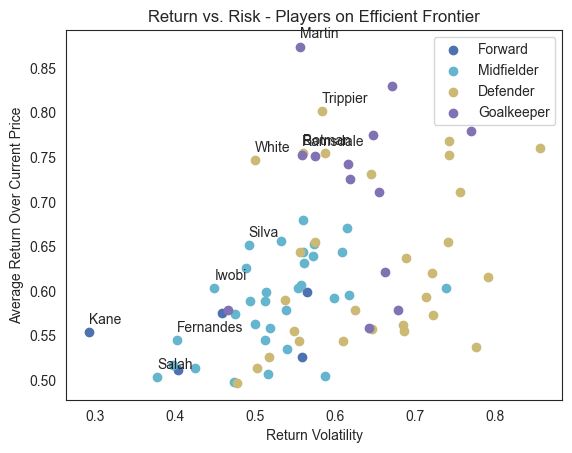

In [894]:
# plot efficient frontier players
def plotEfficientFrontier(df_eft, y_offset, y_lable, x_max = None, x_min = None, y_max = None, y_min = None):
    colors = {'Forward': 'b', 'Midfielder': 'c', 'Defender': 'y', 'Goalkeeper': 'm'}

    for i, position in enumerate(colors.keys()):

        df = df_eft[df_eft['position'] == position]
        x = list(df['pts_rt_std'])
        y = list(df['ave_pts_rt'])
        plt.scatter(x, y, color=colors[position])
        for j, player in enumerate(df['name']):
            if float(list(df['adj_pts_rt'])[j]) >= df['adj_pts_rt'].quantile(0.9):
                plt.annotate(player.split(' ')[-1], (x[j], y[j] + y_offset))

    plt.legend(colors.keys(),
            bbox_to_anchor=(1 , 1),
            ncol=1)
    plt.title('Return vs. Risk - Players on Efficient Frontier')
    plt.xlabel('Return Volatility')
    plt.ylabel(y_lable)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()

plotEfficientFrontier(df_eft, 0.01, 'Average Return Over Current Price')

##### Using average game week return over current price as the numerator penalizes player's injury and assumes long-term player ownership
##### Use average return per minute over current price as the numerator below to avoid bias

In [895]:
df_eft_adj = getEfficientFrontierDF(df_eft_raw, df_elements_short, 'ptspm_return')
df_eft_adj.head(50)

,name,team,ave_pts_rt,pts_rt_std,adj_pts_rt,position,selected_by_percent,now_cost
62,Sean Longstaff,Newcastle,0.008055,0.003905,2.062893,Midfielder,0.2,5.0
3,David Raya Martin,Brentford,0.009708,0.006187,1.568931,Goalkeeper,8.9,5.0
38,Andreas Hoelgebaum Pereira,Fulham,0.008128,0.005267,1.543249,Midfielder,3.3,5.5
27,Joe Willock,Newcastle,0.008661,0.005727,1.512193,Midfielder,1.0,5.5
0,Leandro Trossard,Arsenal,0.011563,0.007906,1.462607,Midfielder,4.0,7.0
11,Dan Burn,Newcastle,0.009552,0.006631,1.440494,Defender,3.3,4.5
49,Kenny Tete,Fulham,0.007956,0.005597,1.421591,Defender,0.6,4.5
54,Lucas Tolentino Coelho de Lima,West Ham,0.007621,0.005493,1.387251,Midfielder,1.4,6.0
19,Kieran Trippier,Newcastle,0.009090,0.006622,1.372815,Defender,34.9,6.5
10,Benjamin White,Arsenal,0.009931,0.007297,1.360858,Defender,9.6,5.5


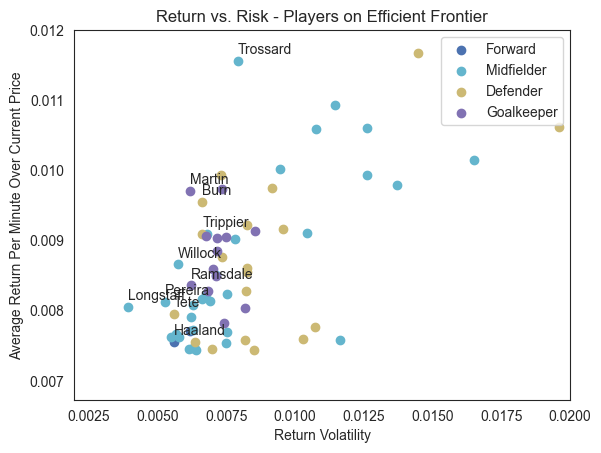

In [896]:
plotEfficientFrontier(df_eft_adj, 0.0001, 'Average Return Per Minute Over Current Price', x_max=0.02, y_max=0.012)

##### Data limiation
Predictors from FPL (i.e. threat, ICT index, influence) are most lagging indicators, lack of player attributes predictors

##### Solution
Feature engineer player attribute predictors from Football Manager

In [897]:
df_master = df_master[df_master['season'] == '2022-23']
df_master.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,starts,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,season,selected_by_percent,now_cost
0,Nathan Redmond,MID,Southampton,1.5,0,0,3,0,0.0,403,0.0,0.0,0.0,0.0,8,0,0,0.0,0.0,2022-08-06T14:00:00Z,1,18,0,0,0,0,1,0,5871,0,1,4,0.0,1,0,0,0,55,False,0,1,2022-23,NaN,NaN
1,Junior Stanislas,MID,Bournemouth,1.1,0,0,3,0,0.0,58,0.0,0.0,0.0,0.0,2,0,0,0.0,0.0,2022-08-06T14:00:00Z,1,2,0,0,0,0,1,0,9491,0,0,2,0.0,1,0,0,0,50,True,0,1,2022-23,NaN,NaN
2,Armando Broja,FWD,Chelsea,2.0,0,0,3,0,0.3,150,0.0,0.0,0.0,0.0,3,0,0,2.5,5.2,2022-08-06T16:30:00Z,15,8,0,0,0,0,1,0,124903,0,1,0,19.0,1,0,0,0,55,False,0,1,2022-23,NaN,NaN
3,Fabian Schär,DEF,Newcastle,2.4,0,3,43,1,14.6,366,0.0,0.0,0.0,0.0,7,0,1,10.6,66.0,2022-08-06T14:00:00Z,90,16,0,0,0,0,1,0,40132,0,0,2,25.0,15,0,0,0,45,True,0,1,2022-23,5.2,5.0
4,Jonny Evans,DEF,Leicester,1.9,0,0,15,0,1.3,249,0.0,0.0,0.0,0.0,6,2,0,1.5,14.0,2022-08-07T13:00:00Z,90,4,0,0,0,0,1,0,24256,0,2,2,0.0,1,0,0,0,45,True,0,1,2022-23,NaN,NaN


In [898]:
file_fm = 'FM/FM 2023.csv'

encoding = getEncoding(file_fm)

df_fm = pd.read_csv(file_fm, encoding = encoding)

df_fm = df_fm.drop_duplicates()

df_fm.head()

,Name,Position,Age,ca,pa,Nationality,Club,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,Adaptation,Ambition,Argue,Loyal,Resistant to stress,Professional,Sportsmanship,Emotional control,GK,DL,DC,DR,WBL,WBR,DM,ML,MC,MR,AML,AMC,AMR,ST,Height,Weight,Left Foot,Right Foot,Values,Current reputation,Domestic reputation,World reputation,Race,RCA,Colour of skin,Date of birth,Number of national team appearances,Goals scored for the national team,Salary,Rental club,UID
0,Kevin De Bruyne,M/AM RLC,31,189,189,Belgium,Manchester City,14,19,15,16,16,17,6,17,7,9,18,16,9,18,12,14,13,15,15,20,18,17,16,13,14,11,14,15,15,13,14,10,16,14,17,13,15,6,15,7,14,1,3,1,3,3,3,3,3,3,2,1,13,17,13,14,11,18,16,13,1,1,1,1,1,1,12,15,20,15,14,20,14,12,181,68,16,20,347975206,9450,9400,9400,Northern_European,181,4,1991/6/28,91,24,394372.0,NaN,18004457
1,Kylian Mbappé,AM/S RL,23,188,197,France,Paris Saint-Germain,13,13,18,17,18,12,7,13,4,4,15,18,4,17,6,17,12,18,14,15,15,15,18,13,18,3,10,10,20,16,15,8,15,20,14,11,15,7,16,7,14,2,2,2,1,1,2,1,3,2,1,2,15,20,8,14,16,16,12,13,1,1,1,1,1,1,1,10,1,10,19,1,17,20,178,73,10,20,347975206,9398,9398,9248,African_Caribbean,172,13,1998/12/20,57,27,1035616.0,NaN,85139014
2,Robert Lewandowski,S,33,186,190,Poland,Barcelona,3,8,13,19,18,15,17,12,3,7,13,20,7,16,15,19,16,17,17,13,17,20,14,15,19,7,12,12,14,13,19,15,20,14,18,16,18,8,15,2,8,2,2,3,2,3,2,3,3,2,1,1,15,20,15,10,16,18,10,11,1,1,1,1,1,1,1,1,1,1,10,12,8,20,185,81,13,20,347975206,9300,9400,9250,Northern_European,183,3,1988/8/21,132,76,345204.0,NaN,719601
3,Erling Haaland,S,22,185,195,"Norway,England",Manchester City,7,10,14,18,16,13,15,13,5,6,13,17,7,15,13,18,15,18,15,14,13,20,16,13,18,7,13,13,17,16,17,18,19,19,14,17,17,9,17,12,10,2,4,1,3,2,2,2,2,3,3,2,16,20,12,15,18,17,10,12,1,1,1,1,1,1,1,1,1,1,1,1,1,20,195,88,20,11,347975206,9250,9250,8750,Northern_European,185,2,2000/7/21,21,20,394372.0,NaN,29179241
4,Mohamed Salah,AM/S RL,30,185,187,Egypt,Liverpool,12,14,17,17,17,12,10,13,6,7,15,17,7,17,11,16,11,15,15,17,15,18,15,11,18,9,15,16,18,16,18,8,17,18,15,15,15,6,16,4,7,3,2,2,1,2,1,3,2,3,3,2,16,19,8,13,16,18,16,17,1,1,1,1,1,1,1,1,1,1,17,12,20,19,175,72,20,8,347975206,9400,9445,8750,North_African__Middle_Eastern,181,9,1992/6/15,85,47,405971.0,NaN,98028755


In [899]:
# find player name in FM mannually before join FM data
name_match_list_fm = [['Miguel Almirón Rejala', 'Miguel Almirón'], 
                        ['David Raya Martin', 'David Raya'],
                        ['Diogo Dalot Teixeira', 'Diogo Dalot'],
                        ['Eberechi Eze', 'Ebere Eze'],
                        ['José Malheiro de Sá', 'José Sá'],
                        ['Lukasz Fabianski', 'Łukasz Fabiański'],
                        ['Gabriel Martinelli Silva', 'Gabriel Martinelli'],
                        ['Alisson Ramses Becker', 'Alisson'],
                        ['Douglas Luiz Soares de Paulo', 'Douglas Luiz'],
                        ['Norberto Murara Neto', 'Pedro Neto'],
                        ['Emiliano Martínez Romero', 'Emiliano Martínez'],
                        ['Gabriel dos Santos Magalhães', 'Gabriel'],
                        ['Andreas Hoelgebaum Pereira', 'Andreas Pereira'],
                        ['Emiliano Buendía Stati', 'Emiliano Buendía'],
                        ['Lucas Tolentino Coelho de Lima', 'Lucas Paquetá'],
                        ['Bernardo Veiga de Carvalho e Silva', 'Bernardo Silva'],
                        ['Ezri Konsa Ngoyo', 'Ezri Konsa'],
                        ['Joelinton Cássio Apolinário de Lira', 'Joelinton'],
                        ['Ederson Santana de Moraes', 'Ederson'],
                        ['Thiago Emiliano da Silva', 'Thiago Silva'],
                        ['Rodrigo Hernandez', 'Rodri'],
                        ['Bobby De Cordova-Reid', 'Bobby Decordova-Reid'],
                        ['Bruno Guimarães Rodriguez Moura', 'Bruno Guimarães'],
                        ['Matheus Luiz Nunes', 'Matheus Nunes'],
                        ['Nélson Cabral Semedo', 'Nélson Semedo'],
                        ['Vitalii Mykolenko', 'Vitaliy Mykolenko'],
                        ['Bruno Borges Fernandes', 'Bruno Fernandes'],
                        ['Jefferson Lerma Solís', 'Jefferson Lerma'],
                        ['Son Heung-min', 'Heung-Min Son'],
                        ['João Palhinha Gonçalves', 'João Palhinha'],
                        ['Fabio Henrique Tavares', 'Fabinho2'],
                        ['Moisés Caicedo Corozo', 'Moisés Caicedo'],
                        ['David De Gea Quintana', 'David De Gea'],
                        ['Rúben da Silva Neves', 'Rúben Neves'],
                        ['Tomas Soucek', 'Tomáš Souček'],
                        ['Ilkay Gündogan', 'İlkay Gündogan'],
                        ['Marc Roca Junqué', 'Marc Roca'],
                        ['Renan Augusto Lodi dos Santos', 'Renan Lodi'],
                        ['Mohamed Elyounoussi', 'Moi Elyounoussi'],
                        ['Vladimir Coufal', 'Vladimír Coufal'],
                        ['Willian Borges da Silva', 'Willian'],
                        ['Jorge Luiz Frello Filho', 'Jorginho'],
                        ['Carlos Henrique Casimiro', 'Casemiro'],
                        ['Gabriel Fernando de Jesus', 'Gabriel Jesus'],
                        ['Rúben Gato Alves Dias', 'Rúben Dias'],
                        ['Rodrigo Moreno', 'Rodrigo'],
                        ['Antony Matheus dos Santos', 'Antony'],
                        ['João Filipe Iria Santos Moutinho', 'João Moutinho'],
                        ['Daniel Castelo Podence', 'Daniel Podence'],
                        ['Emerson Leite de Souza Junior', 'Emerson Royal'],
                        ['Mateo Kovacic', 'Mateo Kovačić'],
                        ['Darwin Núñez Ribeiro', 'Darwin Núñez'],
                        ['Marc Cucurella Saseta', 'Marc Cucurella'],
                        ['Pablo Fornals Malla', 'Pablo Fornals'],
                        ['Adama Traoré Diarra', 'Adama Traoré'],
                        ['Joseph Gomez', 'Joe Gomez'],
                        ['Felipe Augusto de Almeida Monteiro', 'Felipe'],
                        ['Junior Firpo Adames', 'Júnior Firpo'],
                        ['Emerson Palmieri dos Santos', 'Emerson'],
                        ['Hugo Bueno López', 'Hugo Bueno'],
                        ['Jonathan Castro Otto', 'Jonny'],
                        ['Thiago Alcántara do Nascimento', 'Thiago'],
                        ['Diego Da Silva Costa', 'Diego Costa'],
                        ['Frederico Rodrigues de Paula Santos', 'Fred'],
                        ['Joe Ayodele-Aribo', 'Joe Aribo'],
                        ['Lyanco Silveira Neves Vojnovic', 'Lyanco'],
                        ['Diogo Teixeira da Silva', 'Diogo Jota'],
                        ['Hwang Hee-chan', 'Hwang Hee-Chan'],
                        ['Mads Roerslev Rasmussen', 'Mads Roerslev'],
                        ['Carlos Vinícius Alves Morais', 'Carlos Vinícius'],
                        ['Mathias Jorgensen', 'Mathias Jensen'],
                        ['Joel Matip', 'Joël Matip'], 
                        ['Richarlison de Andrade', 'Richarlison'],
                        ['Toti António Gomes', 'Toti'],
                        ['Pedro Lomba Neto', 'Pedro Neto'],
                        ['Matheus Santos Carneiro Da Cunha', 'Matheus Cunha'],
                        ['Duje Caleta-Car', 'Duje Ćaleta-Car'],
                        ['João Félix Sequeira', 'João Félix'],
                        ['Luis Sinisterra Lucumí', 'Luis Sinisterra'],
                        ['Edouard Mendy', 'Édouard Mendy'],
                        ['Philippe Coutinho Correia', 'Philippe Coutinho'],
                        ['Konstantinos Tsimikas', 'Kostas Tsimikas'],
                        ['Gonçalo Manuel Ganchinho Guedes', 'Gonçalo Guedes'],
                        ['Moussa Djenepo', 'Moussa Djénépo'],
                        ['Mykhailo Mudryk', 'Mykhaylo Mudryk'],
                        ['João Victor Gomes da Silva', 'João Gomes'],
                        ['Matt Targett', 'Matthew Targett'],
                        ['Çaglar Söyüncü', 'Çağlar Söyüncü'],
                        ['Stefan Bajcetic', 'Stefan Bajčetić'],
                        ['Cristiano Ronaldo dos Santos Aveiro', 'Cristiano Ronaldo'],
                        ['Luka Milivojevic', 'Luka Milivojević'],
                        ['Fábio Ferreira Vieira', 'Fábio Vieira'],
                        ['Ricardo Barbosa Pereira', 'Ricardo Pereira'],
                        ['Hamed Traorè', 'Hamed Traoré'],
                        ['Sasa Lukic', 'Saša Lukić'],
                        ['Fábio Freitas Gouveia Carvalho', 'Fábio Carvalho'],
                        ['Naby Keita', 'Naby Keïta'],
                        ['Stefan Ortega Moreno', 'Stefan Ortega'],
                        ['Cédric Alves Soares', 'Cédric'],
                        ['Diego Carlos Santos Silva', 'Diego Carlos'],
                        ['Gustavo Henrique Furtado Scarpa', 'Gustavo Scarpa'],
                        ['Jeremy Sarmiento Morante', 'Jeremy Sarmiento'],
                        ['Martin Dubravka', 'Martin Dúbravka'],
                        ['Juan Larios López', 'Juan Larios'],
                        ['Bryan Gil Salvatierra', 'Bryan Gil'],
                        ['Lucas Rodrigues Moura da Silva', 'Lucas Moura'],
                        ['Oriol Romeu Vidal', 'Oriol Romeu'],
                        ['Sergi Canós Tenés', 'Sergi Canos'],
                        ['David Datro Fofana', 'Datro Fofana'],
                        ['Nathaniel Phillips', 'Nathan Phillips'],
                        ['Jairo Riedewald', 'Jaïro Riedewald'],
                        ['Facundo Pellistri Rebollo', 'Facundo Pellistri'],
                        ['Sasa Kalajdzic', 'Saša Kalajdžić'],
                        ['Javier Manquillo Gaitán', 'Javi Manquillo'],
                        ['Dominic Ballard', 'Dom Ballard'],
                        ['Rúben Nascimento Vinagre', 'Rúben Vinagre'],
                        ['Mateo Joseph Fernández', 'Mateo Joseph'],
                        ['Odeluga Offiah', 'Odel Offiah'],
                        ['Mislav Orsic', 'Mislav Oršić'],
                        ['Marcus Oliveira Alencar', 'Marquinhos2']]
df_name_match_fm = pd.DataFrame(name_match_list_fm, columns=['fpl_name', 'fm_name'])

df_fm = df_fm.merge(df_name_match_fm, left_on=['Name'], right_on=['fm_name'], how='left')

In [900]:
df_fm['Merged_Name'] = np.where(df_fm['fpl_name'].notna(), df_fm['fpl_name'], df_fm['Name'])

# add player's best positions column
player_positions = ['GK', 'DL', 'DC', 'DR', 'WBL', 'WBR', 'DM', 'ML', 'MC', 'MR', 'AML', 'AMC', 'AMR', 'ST']
df_fm['best_positions'] = df_fm[player_positions].apply(lambda x: ' '.join(i for i in x[x==20].index), axis=1)
df_fm.head(10)

,Name,Position,Age,ca,pa,Nationality,Club,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,Adaptation,Ambition,Argue,Loyal,Resistant to stress,Professional,Sportsmanship,Emotional control,GK,DL,DC,DR,WBL,WBR,DM,ML,MC,MR,AML,AMC,AMR,ST,Height,Weight,Left Foot,Right Foot,Values,Current reputation,Domestic reputation,World reputation,Race,RCA,Colour of skin,Date of birth,Number of national team appearances,Goals scored for the national team,Salary,Rental club,UID,fpl_name,fm_name,Merged_Name,best_positions
0,Kevin De Bruyne,M/AM RLC,31,189,189,Belgium,Manchester City,14,19,15,16,16,17,6,17,7,9,18,16,9,18,12,14,13,15,15,20,18,17,16,13,14,11,14,15,15,13,14,10,16,14,17,13,15,6,15,7,14,1,3,1,3,3,3,3,3,3,2,1,13,17,13,14,11,18,16,13,1,1,1,1,1,1,12,15,20,15,14,20,14,12,181,68,16,20,347975206,9450,9400,9400,Northern_European,181,4,1991/6/28,91,24,394372.0,NaN,18004457,NaN,NaN,Kevin De Bruyne,MC AMC
1,Kylian Mbappé,AM/S RL,23,188,197,France,Paris Saint-Germain,13,13,18,17,18,12,7,13,4,4,15,18,4,17,6,17,12,18,14,15,15,15,18,13,18,3,10,10,20,16,15,8,15,20,14,11,15,7,16,7,14,2,2,2,1,1,2,1,3,2,1,2,15,20,8,14,16,16,12,13,1,1,1,1,1,1,1,10,1,10,19,1,17,20,178,73,10,20,347975206,9398,9398,9248,African_Caribbean,172,13,1998/12/20,57,27,1035616.0,NaN,85139014,NaN,NaN,Kylian Mbappé,ST
2,Robert Lewandowski,S,33,186,190,Poland,Barcelona,3,8,13,19,18,15,17,12,3,7,13,20,7,16,15,19,16,17,17,13,17,20,14,15,19,7,12,12,14,13,19,15,20,14,18,16,18,8,15,2,8,2,2,3,2,3,2,3,3,2,1,1,15,20,15,10,16,18,10,11,1,1,1,1,1,1,1,1,1,1,10,12,8,20,185,81,13,20,347975206,9300,9400,9250,Northern_European,183,3,1988/8/21,132,76,345204.0,NaN,719601,NaN,NaN,Robert Lewandowski,ST
3,Erling Haaland,S,22,185,195,"Norway,England",Manchester City,7,10,14,18,16,13,15,13,5,6,13,17,7,15,13,18,15,18,15,14,13,20,16,13,18,7,13,13,17,16,17,18,19,19,14,17,17,9,17,12,10,2,4,1,3,2,2,2,2,3,3,2,16,20,12,15,18,17,10,12,1,1,1,1,1,1,1,1,1,1,1,1,1,20,195,88,20,11,347975206,9250,9250,8750,Northern_European,185,2,2000/7/21,21,20,394372.0,NaN,29179241,NaN,NaN,Erling Haaland,ST
4,Mohamed Salah,AM/S RL,30,185,187,Egypt,Liverpool,12,14,17,17,17,12,10,13,6,7,15,17,7,17,11,16,11,15,15,17,15,18,15,11,18,9,15,16,18,16,18,8,17,18,15,15,15,6,16,4,7,3,2,2,1,2,1,3,2,3,3,2,16,19,8,13,16,18,16,17,1,1,1,1,1,1,1,1,1,1,17,12,20,19,175,72,20,8,347975206,9400,9445,8750,North_African__Middle_Eastern,181,9,1992/6/15,85,47,405971.0,NaN,98028755,NaN,NaN,Mohamed Salah,AMR
5,Karim Benzema,S,34,185,185,"France,Algeria",R. Madrid,10,13,16,17,20,12,15,12,7,7,18,15,9,20,7,14,10,18,14,18,17,18,17,11,15,12,16,14,15,14,15,11,11,15,14,14,14,4,15,8,8,3,1,2,3,3,1,2,4,1,2,2,15,14,17,12,15,15,17,18,1,1,1,1,1,1,1,1,1,1,13,12,8,20,185,82,17,20,102955257,9250,8750,8750,North_African__Middle_Eastern,183,9,1987/12/19,97,37,321918.0,NaN,8435089,NaN,NaN,Karim Benzema,ST
6,Harry Kane,S C,28,183,185,"England,Republic of Ireland",Tottenham Hotspur,9,15,14,19,15,10,15,15,6,10,18,20,11,16,11,15,14,18,15,18,18,19,12,15,16,12,18,16,12,12,14,13,16,14,16,15,17,8,14,12,9,1,1,3,1,3,2,1,2,2,3,1,10,18,12,18,18,20,11,16,1,1,1,1,1,1,1,1,11,1,13,15,1,20,188,86,19,20,347975206,9200,9200,8750,Northern_European,183,4,1993/7/28,73,50,231983.0,NaN,28049320,NaN,NaN,Harry Kane,ST
7,Thibaut Courtois,GK,30,181,181,Belgium,R. Madrid,6,1,10,2,10,9,10,1,2,3,13,5,3,12,8,15,15,12,16,9,16,16,14,13,3,16,14,11,12,13,14,18,12,11,8,14,16,5,18,5,15,20,16,14,5,16,16,18,19,12,6,15,14,14,10,15,16,15,14,14,20,1,1,1,1,1,1,1,1,1,1,1,1,1,199,96,20,9,255605643,9050,8750,8500,Northern_European,178,

In [901]:
df_insights = df_master.merge(df_fm, left_on=['name'], right_on=['Merged_Name'], how='left')
df_insights.describe()

,xP,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,fixture,goals_conceded,goals_scored,ict_index,influence,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,starts,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,yellow_cards,GW,now_cost,Age,ca,pa,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,Adaptation,Ambition,Argue,Loyal,Resistant to stress,Professional,Sportsmanship,Emotional control,GK,DL,DC,DR,WBL,WBR,DM,ML,MC,MR,AML,AMC,AMR,ST,Height,Weight,Left Foot,Right Foot,Values,Current reputation,Domestic reputation,World reputation,RCA,Colour of skin,Number of national team appearances,Goals scored for the national team,Salary,UID
count,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,2.650500e+04,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,2.650500e+04,2.650500e+04,2.650500e+04,26505.000000,26505.000000,26505.000000,4573.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.00000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,2.243000e+04,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,22430.000000,2.243000e+04
mean,1.229708,0.034975,0.091945,5.174080,0.087191,3.986636,352.155442,0.016567,0.041239,0.027600,0.301282,199.566648,0.449877,0.039162,1.403701,5.952318,28.263120,10.508319,0.001736,0.000943,0.000641,0.001132,21.219279,0.083984,2.355028e+05,0.202528,1.219694,1.628825,4.106206,1.196906,2.104428e+03,1.612256e+04,1.401812e+04,49.188304,0.051651,21.219279,5.755740,25.283593,135.281275,122.108337,7.986714,10.015738,11.665537,9.488988,12.837628,8.551939,10.265270,9.288988,6.817744,9.332992,12.725011,8.980829,10.594293,13.078065,11.942443,13.023674,12.816496,12.831966,12.075346,11.897637,12.331387,13.889033,11.152341,9.852207,11.565582,11.285600,13.480383,13.934953,13.406821,13.160499,12.862416,11.352207,13.856219,13.383281,13.852608,12.124967,12.823495,8.624922,12.537182,7.804191,11.483861,3.059563,3.022782,2.939322,2.658003,3.066384,2.976594,3.126393,3.146679,2.941864,2.845787,2.867945,12.749532,13.792733,6.480695,12.14757,12.554124,13.918770,12.110522,12.925858,2.528979,5.007757,6.417967,4.568926,4.

In [902]:
df_insights = df_insights[df_insights['minutes'] != 0]

In [903]:
df_check = df_insights[df_insights['Age'].isna()].groupby('name')['minutes'].sum().reset_index()
df_check = df_check.rename(columns={df_check.columns[0]: 'name', df_check.columns[1]: 'minutes'})
df_check = df_check.sort_values(by=['minutes'], ascending=False)

In [904]:
# ensure this returns an empty array to ensure player mapping complete
# otherwise more manual mapping on player name required
print('Number of unmapped players: '+ str(df_insights[df_insights['Age'].isna()]['name'].nunique()))
print('Creating unmapped player list at current directory...')
df_check.to_csv('manualMappingFile.csv')

Number of unmapped players: 33
Creating unmapped player list at current directory...


In [905]:
df_insights = df_insights[df_insights['Age'].notna()]
print('Number of unmapped players after dropping unmapped players: '+ str(df_insights[df_insights['Age'].isna()]['name'].nunique()))

Number of unmapped players after dropping unmapped players: 0


In [906]:
# df_insights[df_insights['name'].str.contains('Mathias Jensen')].head()

In [907]:
# ways to look around to match player name between FPL and FM
# df_insights[df_insights['name'].str.contains('João Palhinha Gonçalves')].head()


# name_try = 'Mathias Jensen'
# df_fm[df_fm['Name'].str.contains(name_try)]

# club_try = 'Wolv'
# df_fm[df_fm['Club'].str.contains(club_try, na=False)]

In [908]:
df_insights.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,starts,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,season,selected_by_percent,now_cost,Name,Position,Age,ca,pa,Nationality,Club,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,Adaptation,Ambition,Argue,Loyal,Resistant to stress,Professional,Sportsmanship,Emotional control,GK,DL,DC,DR,WBL,WBR,DM,ML,MC,MR,AML,AMC,AMR,ST,Height,Weight,Left Foot,Right Foot,Values,Current reputation,Domestic reputation,World reputation,Race,RCA,Colour of skin,Date of birth,Number of national team appearances,Goals scored for the national team,Salary,Rental club,UID,fpl_name,fm_name,Merged_Name,best_positions
0,Nathan Redmond,MID,Southampton,1.5,0,0,3,0,0.0,403,0.0,0.0,0.0,0.0,8,0,0,0.0,0.0,2022-08-06T14:00:00Z,1,18,0,0,0,0,1,0,5871,0,1,4,0.0,1,0,0,0,55,False,0,1,2022-23,NaN,NaN,Nathan Redmond,M/AM/S RLC,28.0,134.0,145.0,"England,Jamaica,Republic of Ireland",Beşiktaş A.Ş.,7.0,13.0,14.0,12.0,13.0,8.0,5.0,13.0,3.0,7.0,12.0,6.0,8.0,14.0,12.0,13.0,13.0,11.0,13.0,12.0,13.0,15.0,14.0,4.0,13.0,11.0,13.0,14.0,14.0,13.0,15.0,6.0,14.0,15.0,13.0,9.0,14.0,7.0,12.0,5.0,9.0,1.0,1.0,2.0,1.0,4.0,3.0,3.0,2.0,2.0,3.0,1.0,8.0,13.0,5.0,15.0,12.0,13.0,15.0,14.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,18.0,1.0,14.0,20.0,18.0,17.0,18.0,173.0,75.0,8.0,20.0,5983867.0,6800.0,6700.0,5700.0,Mixed_Race,124.0,12.0,1994/3/6,1.0,0.0,48076.0,NaN,28053447.0,NaN,NaN,Nathan Redmond,AML
1,Junior Stanislas,MID,Bournemouth,1.1,0,0,3,0,0.0,58,0.0,0.0,0.0,0.0,2,0,0,0.0,0.0,2022-08-06T14:00:00Z,1,2,0,0,0,0,1,0,9491,0,0,2,0.0,1,0,0,0,50,True,0,1,2022-23,NaN,NaN,Junior Stanislas,M/AM RL,32.0,122.0,143.0,"England,Saint Lucia",AFC Bournemouth,15.0,11.0,12.0,11.0,13.0,14.0,7.0,10.0,7.0,7.0,13.0,10.0,8.0,13.0,7.0,14.0,4.0,12.0,10.0,12.0,12.0,13.0,12.0,5.0,12.0,9.0,14.0,12.0,14.0,13.0,13.0,9.0,15.0,14.0,14.0,10.0,15.0,6.0,11.0,13.0,14.0,1.0,3.0,1.0,2.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,12.0,14.0,3.0,13.0,10.0,16.0,8.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,17.0,1.0,17.0,20.0,13.0,20.0,1.0,183.0,77.0,9.0,20.0,2461823.0,6100.0,6100.0,4500.0,Mixed_Race,120.0,16.0,1989/11/26,0.0,0.0,28998.0,NaN,28006277.0,NaN,NaN,Junior Stanislas,AML AMR
2,Armando Broja,FWD,Chelsea,2.0,0,0,3,0,0.3,150,0.0,0.0,0.0,0.0,3,0,0,2.5,5.2,2022-08-06T16:30:00Z,15,8,0,0,0,0,1,0,124903,0,1,0,19.0,1,0,0,0,55,False,0,1,2022-23,NaN,NaN,Armando Broja,AM/S RL,20.0,135.0,-85.0,"Albania,England",Chelsea,7.0,8.0,15.0,14.0,12.0,7.0,12.0,8.0,7.0,5.0,7.0,8.0,8.0,13.0,14.0,13.0,11.0,14.0,8.0,9.0,12.0,12.0,13.0,11.0,14.0,6.0,11.0,13.0,16.0,12.0,15.0,14.0,14.0,16.0,13.0,14.0,10.0,7.0,10.0,6.0,11.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,3.0,1.0,2.0,1.0,13.0,10.0,6.0,10.0,12.0,12.0,12.0,12.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0,14.0,16.0,20.0,191.0,75.0,10.0,20.0,75046653.0,6750.0,6750.0,5500.0,Mediterranean_Hispanic,130.0,2.0,2001/9/10,14.0,4.0,86994.0,NaN,28121369.0,NaN,NaN,Armando Broja,ST
3,Fabian Schär,DEF,Newcastle,2.4,0,3,43,1,14.6,366,0.0,0.0,0.0,0.0,7,0,1,10.6,66.0,2022-08-06T14:00:00Z,90,16,0,0,0,0,1,0,40132,0,0,2,25.0,15,0,0,0,45,True,0,1,2022-23,5.2,5.0,Fabian Schär,D C,30.0,138.0,138.0,Switzerland,Newcastle United,6.0,9.0,12.0,10.0,13.0,12.0,15.0,12.0,8.0,15.0,13.0,14.0,15.0

In [909]:
file_team = 'Fantasy-Premier-League/data/2022-23/teams.csv'

encoding = getEncoding(file_team)

df_team = pd.read_csv(file_team, encoding = encoding)

df_team.columns = 'opponent_team_' + df_team.columns

df_team.head()

,opponent_team_code,opponent_team_draw,opponent_team_form,opponent_team_id,opponent_team_loss,opponent_team_name,opponent_team_played,opponent_team_points,opponent_team_position,opponent_team_short_name,opponent_team_strength,opponent_team_team_division,opponent_team_unavailable,opponent_team_win,opponent_team_strength_overall_home,opponent_team_strength_overall_away,opponent_team_strength_attack_home,opponent_team_strength_attack_away,opponent_team_strength_defence_home,opponent_team_strength_defence_away,opponent_team_pulse_id
0,3,0,NaN,1,0,Arsenal,0,0,0,ARS,4,NaN,False,0,1245,1285,1250,1250,1240,1320,1
1,7,0,NaN,2,0,Aston Villa,0,0,0,AVL,3,NaN,False,0,1070,1100,1070,1075,1070,1130,2
2,91,0,NaN,3,0,Bournemouth,0,0,0,BOU,2,NaN,False,0,1035,1095,1020,1110,1050,1080,127
3,94,0,NaN,4,0,Brentford,0,0,0,BRE,3,NaN,False,0,1115,1180,1100,1160,1130,1200,130
4,36,0,NaN,5,0,Brighton,0,0,0,BHA,3,NaN,False,0,1170,1175,1140,1150,1200,1200,131


In [910]:
df_insights = df_insights.merge(df_team, how='left', left_on='opponent_team', right_on='opponent_team_id')

In [911]:
# reformat columns to be useful for analysis
# create AM/PM and weekday columns for when the game was held
df_insights['kickoff_time'] = pd.to_datetime(df_insights['kickoff_time'], format='%Y-%m-%dT%H:%M:%SZ')
df_insights['AM/PM'] = df_insights['kickoff_time'].dt.strftime('%p')
df_insights['weekday'] = df_insights['kickoff_time'].dt.dayofweek

# chang was_home column to binary
df_insights['was_home'] = np.where(df_insights['was_home'] == False, 0, 1)

In [912]:
# load in prediction dataframe
player_attribute_list = ['ca', 'Corners', 'Crossing', 'Dribbling', \
                        'Finishing', 'First Touch', 'Free Kick Taking', 'Heading', 'Long Shots', 'Long Throws', 'Marking', 'Passing', 'Penalty Taking', \
                        'Tackling', 'Technique', 'Aggressiion', 'Anticipation', 'Bravery', 'Composure', 'Concentration', 'Vision', 'Decision', 'Determination', \
                        'Flair', 'Leadership', 'Off The Ball', 'Position.1', 'Teamwork', 'Work Rate', 'Acceleration', 'Agility', 'Balance', 'Jumping Reach', \
                        'Natural Fitness', 'Pace', 'Stamina', 'Strength', 'Stability', 'Foul', 'Contest performance', 'Injury', 'diversity', 'Aerial Reach', \
                        'Command Of Area', 'Communication',	'Eccentricity', 'Handling',	'Kicking', 'One On Ones', 'Reflexes', 'Rushing Out', 'Punching', 'Throwing']

df_aggregate = df_insights[['position', 'best_positions', 'team', 'AM/PM', 'weekday', 'minutes', 'was_home', 'GW', 'Age', 'Height', 'Weight', 'Left Foot', 'Right Foot'] + player_attribute_list + \
                            ['opponent_team_name', 'total_points']]

In [913]:
df_aggregate.head()

,position,best_positions,team,AM/PM,weekday,minutes,was_home,GW,Age,Height,Weight,Left Foot,Right Foot,ca,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,opponent_team_name,total_points
0,MID,AML,Southampton,PM,5,1,0,1,28.0,173.0,75.0,8.0,20.0,134.0,7.0,13.0,14.0,12.0,13.0,8.0,5.0,13.0,3.0,7.0,12.0,6.0,8.0,14.0,12.0,13.0,13.0,11.0,13.0,12.0,13.0,15.0,14.0,4.0,13.0,11.0,13.0,14.0,14.0,13.0,15.0,6.0,14.0,15.0,13.0,9.0,14.0,7.0,12.0,5.0,9.0,1.0,1.0,2.0,1.0,4.0,3.0,3.0,2.0,2.0,3.0,1.0,Spurs,1
1,MID,AML AMR,Bournemouth,PM,5,1,1,1,32.0,183.0,77.0,9.0,20.0,122.0,15.0,11.0,12.0,11.0,13.0,14.0,7.0,10.0,7.0,7.0,13.0,10.0,8.0,13.0,7.0,14.0,4.0,12.0,10.0,12.0,12.0,13.0,12.0,5.0,12.0,9.0,14.0,12.0,14.0,13.0,13.0,9.0,15.0,14.0,14.0,10.0,15.0,6.0,11.0,13.0,14.0,1.0,3.0,1.0,2.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,Aston Villa,1
2,FWD,ST,Chelsea,PM,5,15,0,1,20.0,191.0,75.0,10.0,20.0,135.0,7.0,8.0,15.0,14.0,12.0,7.0,12.0,8.0,7.0,5.0,7.0,8.0,8.0,13.0,14.0,13.0,11.0,14.0,8.0,9.0,12.0,12.0,13.0,11.0,14.0,6.0,11.0,13.0,16.0,12.0,15.0,14.0,14.0,16.0,13.0,14.0,10.0,7.0,10.0,6.0,11.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,3.0,1.0,2.0,1.0,Everton,1
3,DEF,DC,Newcastle,PM,5,90,1,1,30.0,188.0,84.0,12.0,20.0,138.0,6.0,9.0,12.0,10.0,13.0,12.0,15.0,12.0,8.0,15.0,13.0,14.0,15.0,12.0,17.0,13.0,13.0,14.0,14.0,14.0,12.0,12.0,9.0,11.0,9.0,15.0,16.0,12.0,10.0,10.0,12.0,14.0,12.0,13.0,13.0,15.0,12.0,15.0,14.0,10.0,4.0,4.0,2.0,3.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,Nott'm Forest,15
4,DEF,DC,Leicester,PM,6,90,1,1,34.0,188.0,77.0,16.0,20.0,148.0,4.0,5.0,10.0,6.0,12.0,4.0,15.0,3.0,9.0,16.0,12.0,5.0,16.0,13.0,12.0,17.0,14.0,15.0,15.0,13.0,13.0,15.0,3.0,15.0,6.0,15.0,14.0,14.0,12.0,11.0,15.0,15.0,11.0,10.0,13.0,15.0,17.0,8.0,14.0,12.0,15.0,2.0,2.0,3.0,1.0,2.0,4.0,1.0,3.0,1.0,1.0,1.0,Brentford,1


In [914]:
# df_def_ca_map = df_insights[(df_insights['position'].str.contains('|'.join(['GK', 'DEF'])))].groupby(['team', 'GW'])['ca'].mean().reset_index()
# df_def_ca_map = df_def_ca_map.rename(columns={df_def_ca_map.columns[0]: 'team', df_def_ca_map.columns[1]: 'GW', df_def_ca_map.columns[2]: 'team_def_ca'})
# df_aggregate = df_aggregate.merge(df_def_ca_map, how='left', on=['team', 'GW'])
# df_atk_ca_map = df_insights[(df_insights['position'].str.contains('|'.join(['MID', 'FWD'])))].groupby(['team', 'GW'])['ca'].mean().reset_index()
# df_atk_ca_map = df_atk_ca_map.rename(columns={df_atk_ca_map.columns[0]: 'team', df_atk_ca_map.columns[1]: 'GW', df_atk_ca_map.columns[2]: 'team_atk_ca'})
# df_aggregate = df_aggregate.merge(df_atk_ca_map, how='left', on=['team', 'GW'])

In [915]:
# function to add a column with aggregated metric specified
def getAggregatedMetric(df, metric_name, position_field='position', agg_field_list=['team', 'GW'], attribute='ca', positions_list=None, opponent_dict=None):
    
    if opponent_dict:
        agg_field_list = agg_field_list + [position_field]
        df_map = pd.DataFrame()
        for key, lst in opponent_dict.items():
            # print(df_map.head())
            # print(key, lst, position_field, agg_field_list, attribute)
            df_temp = df[(df[position_field].str.contains('|'.join(lst)))].groupby(agg_field_list[:-1])[attribute].mean().reset_index()
            df_temp[position_field] = key
            df_map = pd.concat([df_map, df_temp], ignore_index=True)
            # print(df_map.head())
        agg_field_list = ['opponent_team_name' if agg_field == 'team' else agg_field for agg_field in agg_field_list]
        df_map = df_map.rename(columns={'team': 'opponent_team_name'})
        # update column name 'team' into 'opponent_team_name' as well
    else:
        df_map = df[(df[position_field].str.contains('|'.join(positions_list)))].groupby(agg_field_list)[attribute].mean().reset_index()
    df_map = df_map.rename(columns={attribute: metric_name})
    # print(df_map.tail())
    # print(df_map.shape)
    # print(agg_field_list)
    return df.merge(df_map, how='left', on=agg_field_list)

In [916]:
df_aggregate = getAggregatedMetric(df_aggregate, positions_list=['GK', 'DEF'], metric_name='team_defence_ca')
df_aggregate = getAggregatedMetric(df_aggregate, positions_list=['MID', 'FWD'], metric_name='team_attack_ca')
df_aggregate.head()

,position,best_positions,team,AM/PM,weekday,minutes,was_home,GW,Age,Height,Weight,Left Foot,Right Foot,ca,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,opponent_team_name,total_points,team_defence_ca,team_attack_ca
0,MID,AML,Southampton,PM,5,1,0,1,28.0,173.0,75.0,8.0,20.0,134.0,7.0,13.0,14.0,12.0,13.0,8.0,5.0,13.0,3.0,7.0,12.0,6.0,8.0,14.0,12.0,13.0,13.0,11.0,13.0,12.0,13.0,15.0,14.0,4.0,13.0,11.0,13.0,14.0,14.0,13.0,15.0,6.0,14.0,15.0,13.0,9.0,14.0,7.0,12.0,5.0,9.0,1.0,1.0,2.0,1.0,4.0,3.0,3.0,2.0,2.0,3.0,1.0,Spurs,1,135.500000,135.111111
1,MID,AML AMR,Bournemouth,PM,5,1,1,1,32.0,183.0,77.0,9.0,20.0,122.0,15.0,11.0,12.0,11.0,13.0,14.0,7.0,10.0,7.0,7.0,13.0,10.0,8.0,13.0,7.0,14.0,4.0,12.0,10.0,12.0,12.0,13.0,12.0,5.0,12.0,9.0,14.0,12.0,14.0,13.0,13.0,9.0,15.0,14.0,14.0,10.0,15.0,6.0,11.0,13.0,14.0,1.0,3.0,1.0,2.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,Aston Villa,1,127.200000,129.555556
2,FWD,ST,Chelsea,PM,5,15,0,1,20.0,191.0,75.0,10.0,20.0,135.0,7.0,8.0,15.0,14.0,12.0,7.0,12.0,8.0,7.0,5.0,7.0,8.0,8.0,13.0,14.0,13.0,11.0,14.0,8.0,9.0,12.0,12.0,13.0,11.0,14.0,6.0,11.0,13.0,16.0,12.0,15.0,14.0,14.0,16.0,13.0,14.0,10.0,7.0,10.0,6.0,11.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,3.0,1.0,2.0,1.0,Everton,1,159.428571,156.888889
3,DEF,DC,Newcastle,PM,5,90,1,1,30.0,188.0,84.0,12.0,20.0,138.0,6.0,9.0,12.0,10.0,13.0,12.0,15.0,12.0,8.0,15.0,13.0,14.0,15.0,12.0,17.0,13.0,13.0,14.0,14.0,14.0,12.0,12.0,9.0,11.0,9.0,15.0,16.0,12.0,10.0,10.0,12.0,14.0,12.0,13.0,13.0,15.0,12.0,15.0,14.0,10.0,4.0,4.0,2.0,3.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,Nott'm Forest,15,140.166667,138.300000
4,DEF,DC,Leicester,PM,6,90,1,1,34.0,188.0,77.0,16.0,20.0,148.0,4.0,5.0,10.0,6.0,12.0,4.0,15.0,3.0,9.0,16.0,12.0,5.0,16.0,13.0,12.0,17.0,14.0,15.0,15.0,13.0,13.0,15.0,3.0,15.0,6.0,15.0,14.0,14.0,12.0,11.0,15.0,15.0,11.0,10.0,13.0,15.0,17.0,8.0,14.0,12.0,15.0,2.0,2.0,3.0,1.0,2.0,4.0,1.0,3.0,1.0,1.0,1.0,Brentford,1,142.333333,148.666667


In [917]:
# create a dictionary maps to opponennt positions based on player positions
# i.e. the player's performance will be directly related to how good the player's mapped opponents
opponent_dict = {
    'GK': ['ML','MC','MR','AML','AMC','AMR','ST'],
    'DL': ['ML','MC','MR','AML','AMC','AMR','ST'],
    'DC': ['ML','MC','MR','AML','AMC','AMR','ST'],
    'DR': ['ML','MC','MR','AML','AMC','AMR','ST'],
    'WBL': ['ML','MC','MR','AML','AMC','AMR','ST'],
    'WBR': ['ML','MC','MR','AML','AMC','AMR','ST'],
    'DM': ['GK','DL','DC','DR','WBL','WBR','DM'],
    'ML': ['GK','DC','DR','WBR','DM'],
    'MC': ['GK','DL','DC','DR','DM'],
    'MR': ['GK','DL','DC','WBL','DM'],
    'AML': ['GK','DC','DR','WBR'],
    'AMC': ['GK','DL','DC','DR','DM'],
    'AMR': ['GK','DL','DC','WBL'],
    'ST': ['GK','DL','DC','DR']
}

# only get the most attacking position out of all the best positions
df_aggregate['best_positions'] = np.where(df_aggregate['best_positions'].str.contains(' '), df_aggregate['best_positions'].str.split(' ').str[-1], df_aggregate['best_positions'])

# get opponent attributes
df_aggregate = getAggregatedMetric(df_aggregate, metric_name='opponent_height', position_field='best_positions', attribute='Height', opponent_dict=opponent_dict)
df_aggregate = getAggregatedMetric(df_aggregate, metric_name='opponent_weight', position_field='best_positions', attribute='Weight', opponent_dict=opponent_dict)
df_aggregate = getAggregatedMetric(df_aggregate, metric_name='opponent_left_foot', position_field='best_positions', attribute='Left Foot', opponent_dict=opponent_dict)
df_aggregate = getAggregatedMetric(df_aggregate, metric_name='opponent_right_foot', position_field='best_positions', attribute='Right Foot', opponent_dict=opponent_dict)
df_aggregate = getAggregatedMetric(df_aggregate, metric_name='opponent_ca', position_field='best_positions', attribute='ca', opponent_dict=opponent_dict)
df_aggregate.head()

,position,best_positions,team,AM/PM,weekday,minutes,was_home,GW,Age,Height,Weight,Left Foot,Right Foot,ca,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,opponent_team_name,total_points,team_defence_ca,team_attack_ca,opponent_height,opponent_weight,opponent_left_foot,opponent_right_foot,opponent_ca
0,MID,AML,Southampton,PM,5,1,0,1,28.0,173.0,75.0,8.0,20.0,134.0,7.0,13.0,14.0,12.0,13.0,8.0,5.0,13.0,3.0,7.0,12.0,6.0,8.0,14.0,12.0,13.0,13.0,11.0,13.0,12.0,13.0,15.0,14.0,4.0,13.0,11.0,13.0,14.0,14.0,13.0,15.0,6.0,14.0,15.0,13.0,9.0,14.0,7.0,12.0,5.0,9.0,1.0,1.0,2.0,1.0,4.0,3.0,3.0,2.0,2.0,3.0,1.0,Spurs,1,135.500000,135.111111,185.666667,83.333333,14.166667,15.500000,146.000000
1,MID,AMR,Bournemouth,PM,5,1,1,1,32.0,183.0,77.0,9.0,20.0,122.0,15.0,11.0,12.0,11.0,13.0,14.0,7.0,10.0,7.0,7.0,13.0,10.0,8.0,13.0,7.0,14.0,4.0,12.0,10.0,12.0,12.0,13.0,12.0,5.0,12.0,9.0,14.0,12.0,14.0,13.0,13.0,9.0,15.0,14.0,14.0,10.0,15.0,6.0,11.0,13.0,14.0,1.0,3.0,1.0,2.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,Aston Villa,1,127.200000,129.555556,184.750000,78.750000,12.000000,16.250000,146.000000
2,FWD,ST,Chelsea,PM,5,15,0,1,20.0,191.0,75.0,10.0,20.0,135.0,7.0,8.0,15.0,14.0,12.0,7.0,12.0,8.0,7.0,5.0,7.0,8.0,8.0,13.0,14.0,13.0,11.0,14.0,8.0,9.0,12.0,12.0,13.0,11.0,14.0,6.0,11.0,13.0,16.0,12.0,15.0,14.0,14.0,16.0,13.0,14.0,10.0,7.0,10.0,6.0,11.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,3.0,1.0,2.0,1.0,Everton,1,159.428571,156.888889,185.142857,63.571429,11.571429,16.857143,135.857143
3,DEF,DC,Newcastle,PM,5,90,1,1,30.0,188.0,84.0,12.0,20.0,138.0,6.0,9.0,12.0,10.0,13.0,12.0,15.0,12.0,8.0,15.0,13.0,14.0,15.0,12.0,17.0,13.0,13.0,14.0,14.0,14.0,12.0,12.0,9.0,11.0,9.0,15.0,16.0,12.0,10.0,10.0,12.0,14.0,12.0,13.0,13.0,15.0,12.0,15.0,14.0,10.0,4.0,4.0,2.0,3.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,Nott'm Forest,15,140.166667,138.300000,180.666667,48.000000,9.666667,20.000000,127.166667
4,DEF,DC,Leicester,PM,6,90,1,1,34.0,188.0,77.0,16.0,20.0,148.0,4.0,5.0,10.0,6.0,12.0,4.0,15.0,3.0,9.0,16.0,12.0,5.0,16.0,13.0,12.0,17.0,14.0,15.0,15.0,13.0,13.0,15.0,3.0,15.0,6.0,15.0,14.0,14.0,12.0,11.0,15.0,15.0,11.0,10.0,13.0,15.0,17.0,8.0,14.0,12.0,15.0,2.0,2.0,3.0,1.0,2.0,4.0,1.0,3.0,1.0,1.0,1.0,Brentford,1,142.333333,148.666667,178.750000,57.000000,13.750000,16.000000,131.625000


In [918]:
df_aggregate['vs_opp_ca'] = df_aggregate['ca']/df_aggregate['opponent_ca']
df_aggregate['vs_opp_height'] = df_aggregate['Height']/df_aggregate['opponent_height']
df_aggregate['vs_opp_weight'] = df_aggregate['Weight']/df_aggregate['opponent_weight']

In [919]:
df_gw1_liv = df_aggregate[(df_aggregate['team'] == 'Liverpool') & (df_aggregate['GW'] == 1)]
df_gw1_liv.head()

,position,best_positions,team,AM/PM,weekday,minutes,was_home,GW,Age,Height,Weight,Left Foot,Right Foot,ca,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,opponent_team_name,total_points,team_defence_ca,team_attack_ca,opponent_height,opponent_weight,opponent_left_foot,opponent_right_foot,opponent_ca,vs_opp_ca,vs_opp_height,vs_opp_weight
10,GK,GK,Liverpool,AM,5,90,0,1,29.0,191.0,91.0,9.0,20.0,177.0,3.0,3.0,10.0,3.0,15.0,2.0,7.0,3.0,3.0,2.0,14.0,5.0,2.0,14.0,12.0,17.0,14.0,17.0,15.0,11.0,16.0,19.0,13.0,11.0,11.0,18.0,11.0,17.0,13.0,16.0,16.0,13.0,17.0,13.0,12.0,15.0,17.0,5.0,16.0,8.0,1.0,15.0,13.0,14.0,12.0,16.0,15.0,18.0,17.0,16.0,14.0,14.0,Fulham,1,166.8,155.8,177.571429,71.714286,12.000000,18.142857,134.571429,1.315287,1.075623,1.268924
44,MID,MC,Liverpool,AM,5,31,0,1,36.0,176.0,70.0,8.0,20.0,143.0,13.0,12.0,10.0,11.0,15.0,9.0,9.0,7.0,13.0,13.0,14.0,16.0,13.0,14.0,15.0,13.0,17.0,14.0,14.0,12.0,13.0,19.0,9.0,17.0,12.0,13.0,18.0,18.0,11.0,10.0,13.0,8.0,19.0,10.0,17.0,15.0,14.0,11.0,15.0,12.0,18.0,3.0,3.0,2.0,3.0,2.0,2.0,2.0,2.0,1.0,4.0,3.0,Fulham,1,166.8,155.8,188.857143,77.142857,12.428571,16.428571,135.000000,1.059259,0.931921,0.907407
96,DEF,WBR,Liverpool,AM,5,90,0,1,23.0,180.0,70.0,12.0,20.0,160.0,15.0,18.0,12.0,10.0,17.0,14.0,11.0,12.0,14.0,11.0,16.0,12.0,13.0,17.0,12.0,13.0,11.0,15.0,12.0,16.0,15.0,15.0,14.0,12.0,15.0,11.0,16.0,14.0,14.0,14.0,14.0,11.0,15.0,14.0,14.0,13.0,13.0,10.0,14.0,7.0,14.0,2.0,2.0,3.0,1.0,1.0,1.0,2.0,1.0,3.0,2.0,2.0,Fulham,1,166.8,155.8,177.571429,71.714286,12.000000,18.142857,134.571429,1.188960,1.013677,0.976096
98,MID,AMR,Liverpool,AM,5,90,0,1,30.0,175.0,72.0,20.0,8.0,185.0,12.0,14.0,17.0,17.0,17.0,12.0,10.0,13.0,6.0,7.0,15.0,17.0,7.0,17.0,11.0,16.0,11.0,15.0,15.0,17.0,15.0,18.0,15.0,11.0,18.0,9.0,15.0,16.0,18.0,16.0,18.0,8.0,17.0,18.0,15.0,15.0,15.0,6.0,16.0,4.0,7.0,3.0,2.0,2.0,1.0,2.0,1.0,3.0,2.0,3.0,3.0,2.0,Fulham,12,166.8,155.8,190.400000,77.000000,13.000000,15.000000,131.200000,1.410061,0.919118,0.935065
118,FWD,ST,Liverpool,AM,5,50,0,1,30.0,181.0,76.0,8.0,20.0,155.0,8.0,12.0,14.0,11.0,17.0,8.0,12.0,10.0,7.0,13.0,13.0,12.0,12.0,18.0,13.0,15.0,11.0,17.0,13.0,16.0,13.0,13.0,16.0,8.0,15.0,13.0,18.0,16.0,13.0,15.0,17.0,10.0,17.0,13.0,16.0,14.0,13.0,7.0,14.0,8.0,11.0,3.0,2.0,1.0,2.0,3.0,2.0,1.0,1.0,2.0,3.0,1.0,Fulham,1,166.8,155.8,188.666667,76.000000,12.500000,15.833333,132.166667,1.172762,0.959364,1.000000


In [920]:
# feature selection for modeling
df_model = df_aggregate[['position', 'AM/PM', 'weekday', 'minutes',
       'was_home', 'Age', 'Left Foot', 'Right Foot', 'vs_opp_ca', 'vs_opp_height',
       'vs_opp_weight', 'Corners', 'Crossing', 'Dribbling', 'Finishing', 'First Touch',
       'Free Kick Taking', 'Heading', 'Long Shots', 'Long Throws', 'Marking',
       'Passing', 'Penalty Taking', 'Tackling', 'Technique', 'Aggressiion',
       'Anticipation', 'Bravery', 'Composure', 'Concentration', 'Vision',
       'Decision', 'Determination', 'Flair', 'Leadership', 'Off The Ball',
       'Position.1', 'Teamwork', 'Work Rate', 'Acceleration', 'Agility',
       'Balance', 'Jumping Reach', 'Natural Fitness', 'Pace', 'Stamina',
       'Strength', 'Stability', 'Foul', 'Contest performance', 'Injury',
       'diversity', 'Aerial Reach', 'Command Of Area', 'Communication',
       'Eccentricity', 'Handling', 'Kicking', 'One On Ones', 'Reflexes',
       'Rushing Out', 'Punching', 'Throwing',
       'total_points', 'team_defence_ca', 'team_attack_ca',
       'opponent_left_foot', 'opponent_right_foot']]

position_dummies = pd.get_dummies(df_model['position'])
am_pm_dummies = pd.get_dummies(df_model['AM/PM'])
df_model = pd.concat([df_model, position_dummies, am_pm_dummies], axis=1)
df_model.drop(['position', 'AM/PM'], inplace=True, axis=1)

print(df_model.shape)
df_model.head()

(11158, 72)


,weekday,minutes,was_home,Age,Left Foot,Right Foot,vs_opp_ca,vs_opp_height,vs_opp_weight,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,total_points,team_defence_ca,team_attack_ca,opponent_left_foot,opponent_right_foot,DEF,FWD,GK,MID,AM,PM
0,5,1,0,28.0,8.0,20.0,0.917808,0.931777,0.900000,7.0,13.0,14.0,12.0,13.0,8.0,5.0,13.0,3.0,7.0,12.0,6.0,8.0,14.0,12.0,13.0,13.0,11.0,13.0,12.0,13.0,15.0,14.0,4.0,13.0,11.0,13.0,14.0,14.0,13.0,15.0,6.0,14.0,15.0,13.0,9.0,14.0,7.0,12.0,5.0,9.0,1.0,1.0,2.0,1.0,4.0,3.0,3.0,2.0,2.0,3.0,1.0,1,135.500000,135.111111,14.166667,15.500000,False,False,False,True,False,True
1,5,1,1,32.0,9.0,20.0,0.835616,0.990528,0.977778,15.0,11.0,12.0,11.0,13.0,14.0,7.0,10.0,7.0,7.0,13.0,10.0,8.0,13.0,7.0,14.0,4.0,12.0,10.0,12.0,12.0,13.0,12.0,5.0,12.0,9.0,14.0,12.0,14.0,13.0,13.0,9.0,15.0,14.0,14.0,10.0,15.0,6.0,11.0,13.0,14.0,1.0,3.0,1.0,2.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,1,127.200000,129.555556,12.000000,16.250000,False,False,False,True,False,True
2,5,15,0,20.0,10.0,20.0,0.993691,1.031636,1.179775,7.0,8.0,15.0,14.0,12.0,7.0,12.0,8.0,7.0,5.0,7.0,8.0,8.0,13.0,14.0,13.0,11.0,14.0,8.0,9.0,12.0,12.0,13.0,11.0,14.0,6.0,11.0,13.0,16.0,12.0,15.0,14.0,14.0,16.0,13.0,14.0,10.0,7.0,10.0,6.0,11.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,3.0,1.0,2.0,1.0,1,159.428571,156.888889,11.571429,16.857143,False,True,False,False,False,True
3,5,90,1,30.0,12.0,20.0,1.085190,1.040590,1.750000,6.0,9.0,12.0,10.0,13.0,12.0,15.0,12.0,8.0,15.0,13.0,14.0,15.0,12.0,17.0,13.0,13.0,14.0,14.0,14.0,12.0,12.0,9.0,11.0,9.0,15.0,16.0,12.0,10.0,10.0,12.0,14.0,12.0,13.0,13.0,15.0,12.0,15.0,14.0,10.0,4.0,4.0,2.0,3.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,15,140.166667,138.300000,9.666667,20.000000,True,False,False,False,False,True
4,6,90,1,34.0,16.0,20.0,1.124406,1.051748,1.350877,4.0,5.0,10.0,6.0,12.0,4.0,15.0,3.0,9.0,16.0,12.0,5.0,16.0,13.0,12.0,17.0,14.0,15.0,15.0,13.0,13.0,15.0,3.0,15.0,6.0,15.0,14.0,14.0,12.0,11.0,15.0,15.0,11.0,10.0,13.0,15.0,17.0,8.0,14.0,12.0,15.0,2.0,2.0,3.0,1.0,2.0,4.0,1.0,3.0,1.0,1.0,1.0,1,142.333333,148.666667,13.750000,16.000000,True,False,False,False,False,True


In [921]:
df_model['GK'].dtype

dtype('bool')

In [922]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_model.loc[:, df_model.columns != 'total_points'], df_model['total_points'], test_size=0.30, random_state=42)
print('X_train shape: ' + str(X_train.shape))
print('y_train shape: ' + str(y_train.shape))
print('X_test shape: ' + str(X_test.shape))
print('y_test shape: ' + str(y_test.shape))

X_train shape: (7810, 71)
y_train shape: (7810,)
X_test shape: (3348, 71)
y_test shape: (3348,)


### Further EDA
##### Plot correlation for independent and dependent variables

In [923]:
# function to plot Pearson and Spearman correlations
def plotNumericCorrelations(xCols, yCols, position=None):
    fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Pearson Correaltion',  'Spearman Correaltion'))
    colorscale=     [[1.0              , "rgb(165,0,38)"],
                    [0.8888888888888888, "rgb(215,48,39)"],
                    [0.7777777777777778, "rgb(244,109,67)"],
                    [0.6666666666666666, "rgb(253,174,97)"],
                    [0.5555555555555556, "rgb(254,224,144)"],
                    [0.4444444444444444, "rgb(224,243,248)"],
                    [0.3333333333333333, "rgb(171,217,233)"],
                    [0.2222222222222222, "rgb(116,173,209)"],
                    [0.1111111111111111, "rgb(69,117,180)"],
                    [0.0               , "rgb(49,54,149)"]]

    df = pd.concat([xCols, yCols], axis=1)

    if position:
        df = df[df[position]==True]
    
    s_val = df.corr('pearson')
    s_idx = s_val.index
    s_col = s_val.columns
    s_val = s_val.values
    fig.add_trace(
        go.Heatmap(x=s_col,y=s_idx,z=s_val,name='pearson',showscale=False,xgap=0.7,ygap=0.7,colorscale=colorscale),
        row=1, col=1
    )


    s_val = df.corr('spearman')
    s_idx = s_val.index
    s_col = s_val.columns
    s_val = s_val.values
    fig.add_trace(
        go.Heatmap(x=s_col,y=s_idx,z=s_val,xgap=0.7,ygap=0.7,colorscale=colorscale),
        row=2, col=1
    )
    fig.update_layout(
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
        )
    )
    fig.update_layout(height=700, width=900, title_text="Numeric Correaltions")
    fig.show()

In [924]:
# correlation for all players
plotNumericCorrelations(X_train, y_train)

In [925]:
# correlation for goalkeepers
plotNumericCorrelations(X_train, y_train, 'GK')

In [926]:
# correlation for defenders
plotNumericCorrelations(X_train, y_train, 'DEF')

In [927]:
# correlation for midfielders
plotNumericCorrelations(X_train, y_train, 'MID')

In [928]:
# corrrelation for forwards
plotNumericCorrelations(X_train, y_train, 'FWD')

##### Plot "Total Points", the variable we're trying to predict

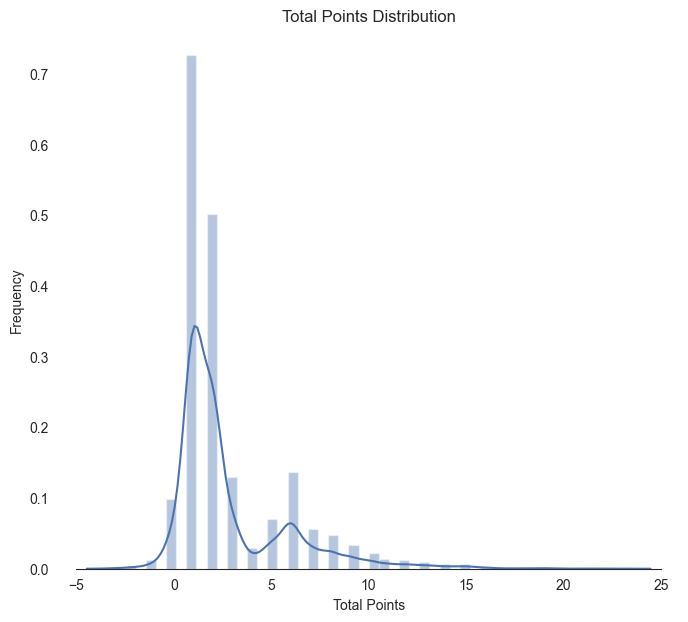

In [929]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(y_train, color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="Total Points")
ax.set(title="Total Points Distribution")
sns.despine(trim=True, left=True)
plt.show()

In [930]:
# skew and kurt
print("Skewness: %f" % y_train.skew())
print("Kurtosis: %f" % y_train.kurt())

Skewness: 1.996177
Kurtosis: 4.680333


#### Problem #1: Total points is highly skewed to the right
This is a problem because most ML models don't do well with non-normally distributed data
#### Problem #2: Total points is also bimodal
This is even a bigger issue since normalization might not help
##### Solution: Try applying a log(1+x) tranform to fix the skew


In [931]:
y_train_transform = np.log10(y_train+(1.000001-y_train.min()))

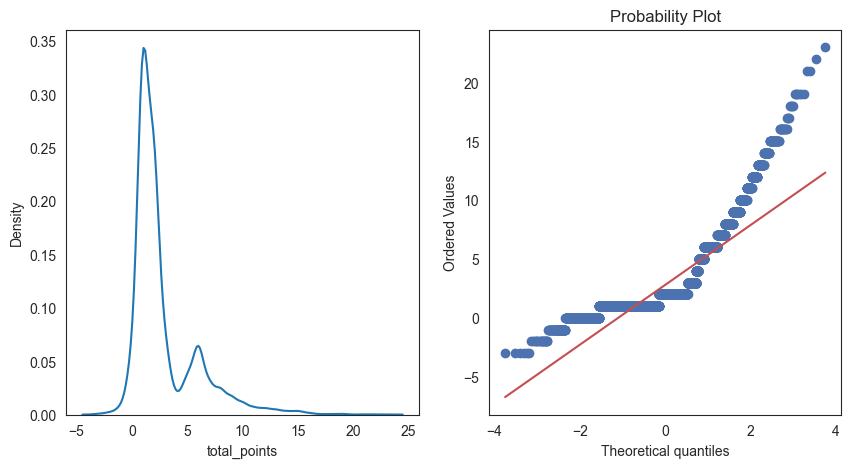

In [932]:
#function to return plots and QoQ plot for the dataframe
def normality(df):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(df)
    plt.subplot(1,2,2)
    stats.probplot(df,plot=pylab)
    plt.show()

# plot dependent variable without transformation
normality(y_train)

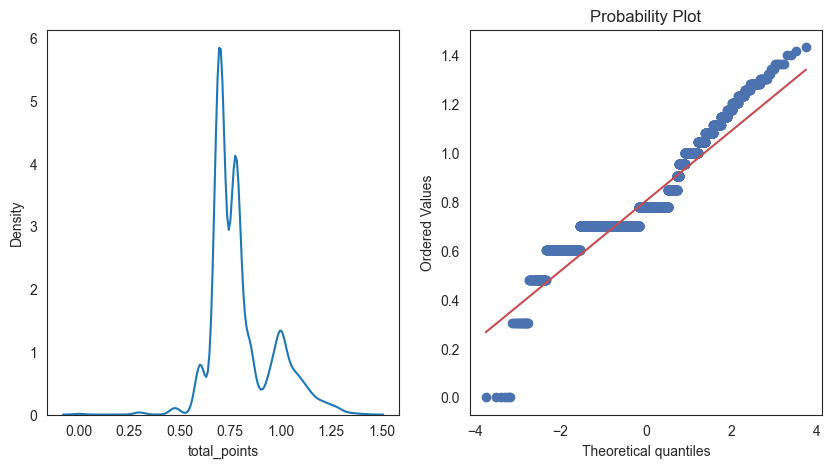

In [933]:
# plot dependent variable with log transformation
normality(y_train_transform)

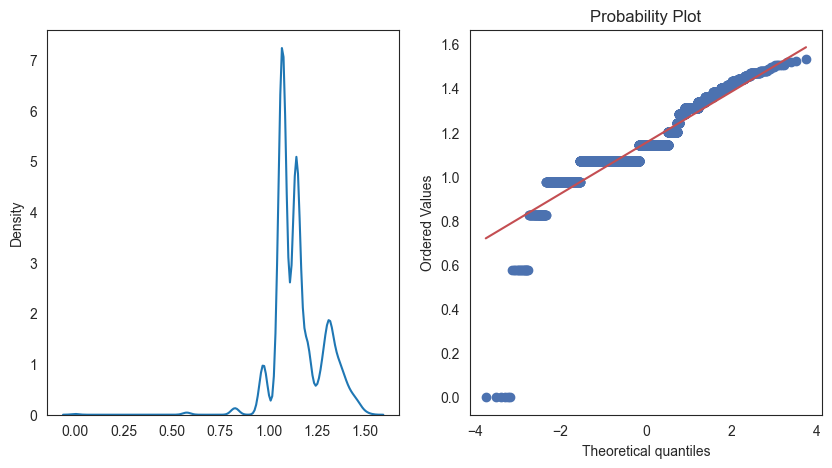

In [934]:
# plot dependent variable with boxcox transformation
y_train_transform_cox, parameters = stats.boxcox(y_train+(1.000001-y_train.min()))
normality(y_train_transform_cox)

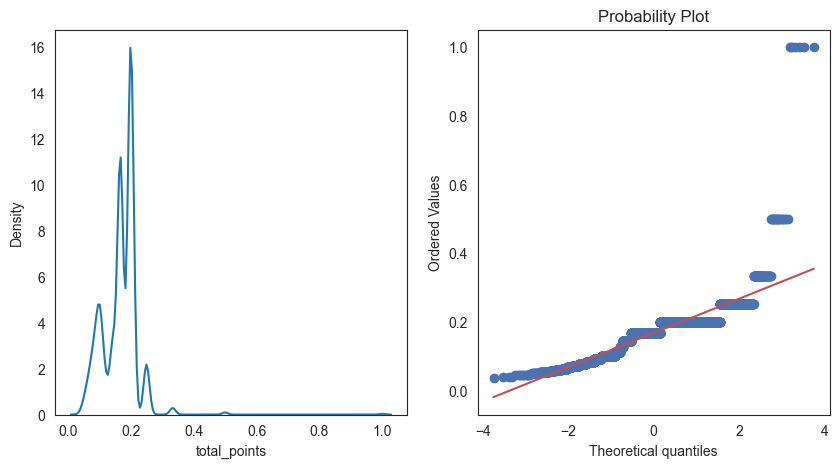

In [935]:
y_train_transform_reciprocal = 1/(y_train+(1.000001-y_train.min()))
normality(y_train_transform_reciprocal)

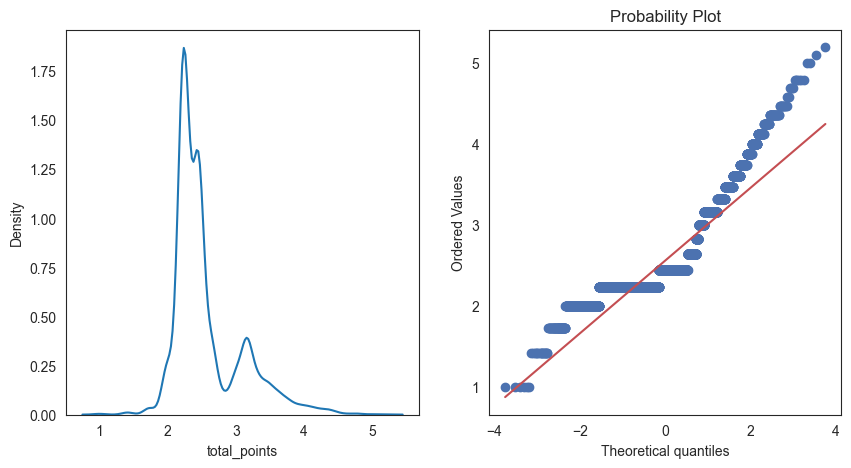

In [936]:
y_train_transform_sqrt = np.sqrt(y_train+(1.000001-y_train.min()))
normality(y_train_transform_sqrt)

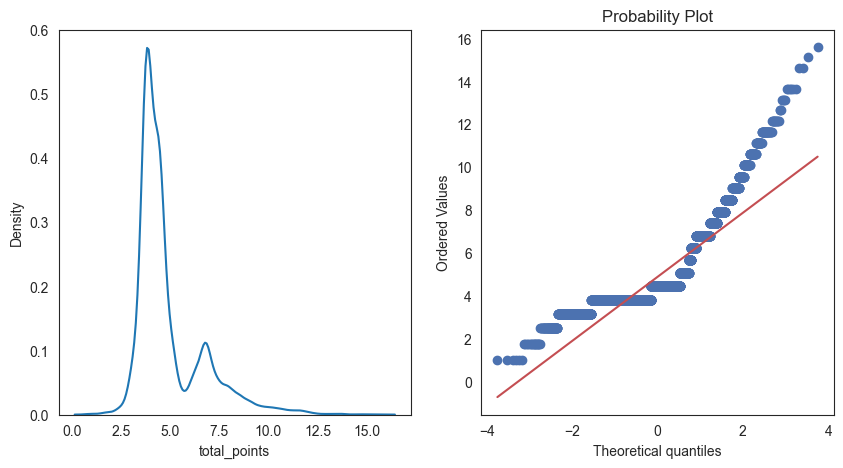

In [937]:
# y_train_transform_exp = (y_train+(1.000001-y_train.min()))**(1/1.2)
y_train_transform_exp = (y_train+(1.000001-y_train.min()))**(1/1.2)
normality(y_train_transform_exp)


 mu = 0.80 and sigma = 0.15



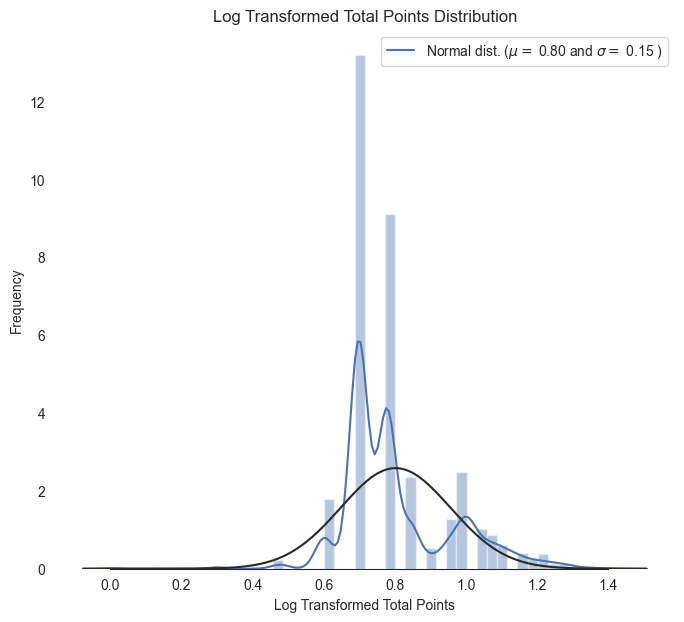

In [938]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(y_train_transform , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_train_transform)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="Log Transformed Total Points")
ax.set(title="Log Transformed Total Points Distribution")
sns.despine(trim=True, left=True)

plt.show()

In [939]:
print('skew before transformation: ' + str(y_train.skew()))
print('skew after transformation: ' + str(y_train_transform.skew()))
print('kurtosis before transformation: ' + str(y_train.kurt()))
print('kurtosis after transformation: ' + str(y_train_transform.kurt()))

skew before transformation: 1.9961773435328012
skew after transformation: 0.8915443072138243
kurtosis before transformation: 4.680333404752563
kurtosis after transformation: 1.2936075808222012


##### Based on charts log transformed depedent variable "Total Points" is closer to normal distribution but definitely not normal
##### Have to live with this as no other options

In [940]:
# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([X_train, X_test]).reset_index(drop=True)
all_features.shape

(11158, 71)

In [941]:
# determine the threshold for missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('weekday', 0.0),
 ('minutes', 0.0),
 ('was_home', 0.0),
 ('Age', 0.0),
 ('Left Foot', 0.0),
 ('Right Foot', 0.0),
 ('vs_opp_ca', 0.0),
 ('vs_opp_height', 0.0),
 ('vs_opp_weight', 0.0),
 ('Corners', 0.0)]

Proof for no missing data, continue

In [942]:
# function to get all numeric features
def getNumericFeatures(features):
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    return numeric

numeric = getNumericFeatures(all_features)

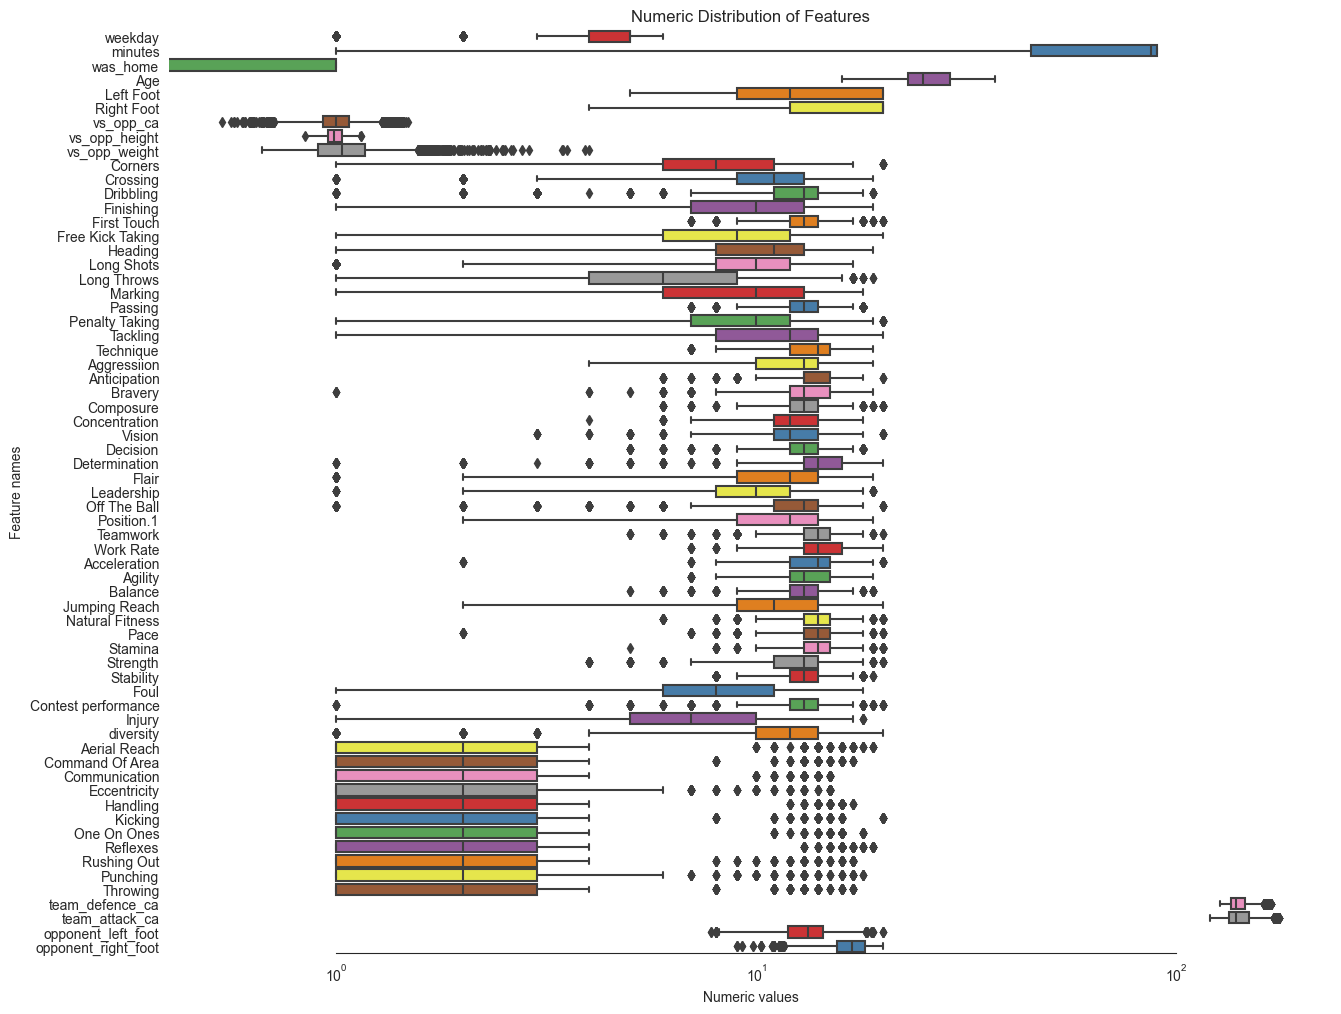

In [943]:
# create box plots for all numeric features
def createBoxPlots(all_features, numeric):
    sns.set_style("white")
    f, ax = plt.subplots(figsize=(15,12))
    ax.set_xscale("log")
    ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
    ax.xaxis.grid(False)
    ax.set(ylabel="Feature names")
    ax.set(xlabel="Numeric values")
    ax.set(title="Numeric Distribution of Features")
    sns.despine(trim=True, left=True)

createBoxPlots(all_features, numeric)

In [944]:
# Find skewed numerical features
def getSkewedNumericalFeatures(all_features, numeric):
    skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

    high_skew = skew_features[skew_features > 0.5]
    skew_index = high_skew.index

    print("There are {} numerical features out of {} features with Skew > 0.5 :".format(high_skew.shape[0], all_features.shape[1]))
    # skewness = pd.DataFrame({'Skew' :high_skew})
    # skew_features.head(10)

    return skew_index, skew_features

skew_index, skew_features = getSkewedNumericalFeatures(all_features, numeric)
skew_features.head(20)

There are 15 numerical features out of 71 features with Skew > 0.5 :


Eccentricity       3.458579
Kicking            3.307109
Rushing Out        3.304009
Punching           3.238090
Reflexes           3.224274
Aerial Reach       3.217383
Command Of Area    3.168203
One On Ones        3.164449
Handling           3.156742
Throwing           3.141910
Communication      3.041619
team_defence_ca    1.211381
team_attack_ca     0.842617
Long Throws        0.567734
Injury             0.532406
Left Foot          0.471520
vs_opp_ca          0.350227
Age                0.322892
Stamina            0.283643
Foul               0.226189
dtype: float64

In [945]:
# apply simple log transformation to normalize skewed features
for i in skew_index:
    all_features[i] = np.log10(all_features[i])

In [946]:
skew_index, skew_features = getSkewedNumericalFeatures(all_features, numeric)
skew_features.head(15)

There are 13 numerical features out of 71 features with Skew > 0.5 :


Reflexes           1.202547
Kicking            1.113768
Handling           1.101250
team_defence_ca    1.081845
Aerial Reach       1.073388
One On Ones        1.032302
Rushing Out        1.000165
Throwing           0.982637
Command Of Area    0.956477
Communication      0.914974
Punching           0.813688
team_attack_ca     0.697145
Eccentricity       0.647658
Left Foot          0.471520
vs_opp_ca          0.350227
dtype: float64

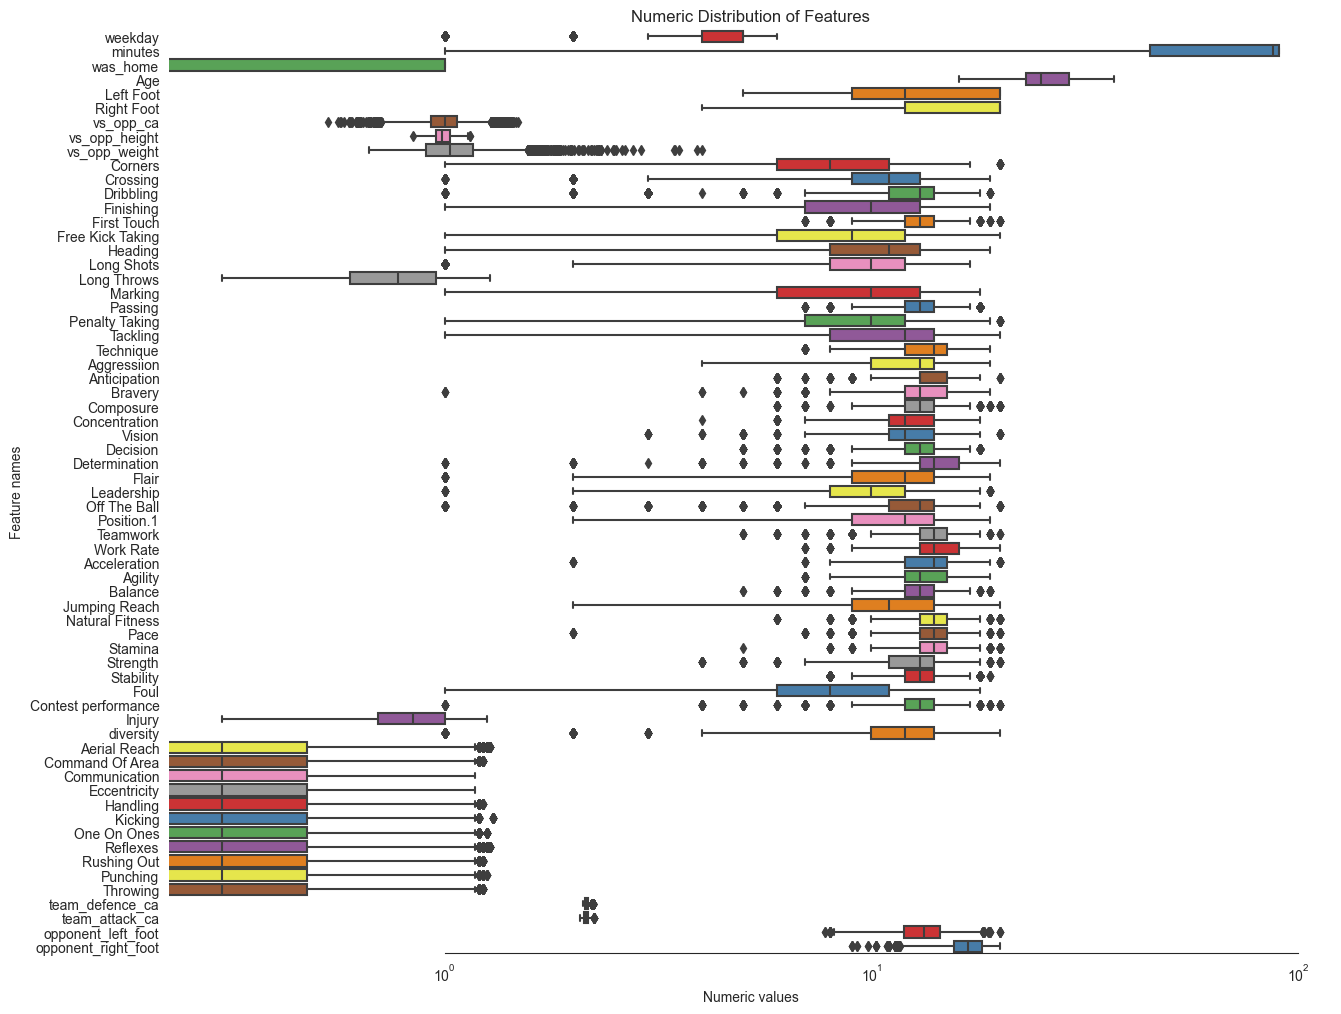

In [954]:
createBoxPlots(all_features, numeric)

skews for features look much closer to normal after log transformation

In [951]:
# update boolean columns to integer so that machine learning models can understand
boolean_dtypes = ['bool']
for i in all_features.columns:
        if all_features[i].dtype in boolean_dtypes:
            all_features[i] = all_features[i].astype(int)

In [953]:
all_features.head()

,weekday,minutes,was_home,Age,Left Foot,Right Foot,vs_opp_ca,vs_opp_height,vs_opp_weight,Corners,Crossing,Dribbling,Finishing,First Touch,Free Kick Taking,Heading,Long Shots,Long Throws,Marking,Passing,Penalty Taking,Tackling,Technique,Aggressiion,Anticipation,Bravery,Composure,Concentration,Vision,Decision,Determination,Flair,Leadership,Off The Ball,Position.1,Teamwork,Work Rate,Acceleration,Agility,Balance,Jumping Reach,Natural Fitness,Pace,Stamina,Strength,Stability,Foul,Contest performance,Injury,diversity,Aerial Reach,Command Of Area,Communication,Eccentricity,Handling,Kicking,One On Ones,Reflexes,Rushing Out,Punching,Throwing,team_defence_ca,team_attack_ca,opponent_left_foot,opponent_right_foot,DEF,FWD,GK,MID,AM,PM
0,5,90,1,29.0,8.0,20.0,0.939010,0.972067,1.000000,7.0,12.0,13.0,10.0,15.0,7.0,14.0,9.0,0.954243,13.0,13.0,6.0,15.0,12.0,15.0,13.0,15.0,14.0,12.0,10.0,12.0,15.0,11.0,10.0,16.0,13.0,15.0,16.0,14.0,13.0,14.0,9.0,15.0,13.0,16.0,14.0,12.0,13.0,14.0,0.845098,12.0,0.477121,0.477121,0.477121,0.000000,0.000000,0.000000,0.477121,0.477121,0.301030,0.000000,0.477121,2.127645,2.113526,12.833333,17.666667,1,0,0,0,0,1
1,6,58,1,23.0,20.0,10.0,1.192857,0.984996,1.135135,11.0,12.0,14.0,16.0,18.0,11.0,13.0,11.0,0.903090,7.0,14.0,12.0,10.0,17.0,11.0,15.0,11.0,17.0,10.0,17.0,16.0,10.0,15.0,7.0,17.0,10.0,15.0,13.0,13.0,13.0,13.0,14.0,16.0,17.0,15.0,13.0,13.0,6.0,16.0,0.602060,16.0,0.301030,0.301030,0.477121,0.000000,0.477121,0.477121,0.477121,0.301030,0.477121,0.301030,0.477121,2.178977,2.167049,15.000000,14.500000,0,1,0,0,0,1
2,5,38,0,29.0,20.0,12.0,0.944882,0.921483,0.790123,10.0,10.0,13.0,9.0,13.0,10.0,8.0,7.0,0.778151,13.0,14.0,9.0,14.0,14.0,15.0,15.0,15.0,10.0,11.0,11.0,11.0,14.0,12.0,8.0,14.0,13.0,17.0,17.0,16.0,16.0,14.0,7.0,15.0,15.0,18.0,13.0,10.0,12.0,14.0,0.477121,12.0,0.301030,0.602060,0.000000,0.301030,0.301030,0.000000,0.477121,0.000000,0.477121,0.477121,0.301030,2.164848,2.177697,13.200000,18.400000,0,0,0,1,0,1
3,5,90,1,25.0,20.0,10.0,1.009975,1.035000,1.226576,6.0,10.0,10.0,8.0,13.0,7.0,14.0,7.0,0.477121,13.0,13.0,6.0,14.0,14.0,10.0,15.0,13.0,13.0,12.0,13.0,13.0,13.0,11.0,13.0,10.0,14.0,15.0,15.0,14.0,11.0,14.0,15.0,14.0,11.0,15.0,12.0,13.0,12.0,13.0,0.778151,3.0,0.000000,0.477121,0.301030,0.000000,0.477121,0.301030,0.301030,0.000000,0.000000,0.477121,0.301030,2.120574,2.117437,14.222222,16.333333,1,0,0,0,0,1
4,6,65,0,25.0,12.0,20.0,0.942661,0.982898,0.958506,12.0,11.0,13.0,11.0,14.0,7.0,11.0,13.0,0.602060,10.0,15.0,14.0,14.0,14.0,15.0,13.0,12.0,14.0,13.0,13.0,13.0,14.0,14.0,10.0,13.0,13.0,14.0,13.0,13.0,12.0,14.0,11.0,14.0,13.0,14.0,13.0,13.0,14.0,13.0,0.954243,11.0,0.301030,0.301030,0.301030,0.477121,0.000000,0.000000,0.000000,0.301030,0.477121,0.301030,0.000000,2.137354,2.136403,12.833333,18.333333,0,0,0,1,0,1
